# ECE 228 Unet (Kaggle nucleus dataset)

# Python imports

In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline  

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms, utils
from skimage import io, transform
from skimage.color import rgb2gray

from models import * 


# Load nucleus data

Training images shape =  (670, 3, 128, 128)
Training labels shape =  (670, 1, 128, 128)


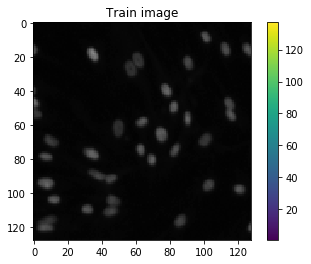

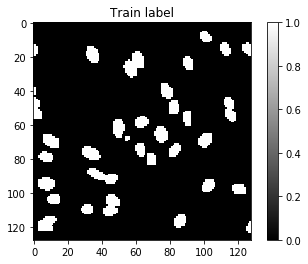

In [2]:
X_train = np.load('datasets/nucleus_train_images.npy')
X_train = (X_train/127)-1
Y_train = np.load('datasets/nucleus_train_labels.npy').astype(np.uint8)

print("Training images shape = ",X_train.shape)
print("Training labels shape = ",Y_train.shape)
original_imgs = (127*(np.moveaxis(X_train, 1, -1)+1)).astype(np.uint8)

plt.imshow(original_imgs[0])
plt.title("Train image")
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(Y_train[0,:,:,:]), cmap="gray")
plt.title("Train label")
plt.colorbar()
plt.show()



# Training Methods 

In [3]:
def f1_score(y_true, y_pred, threshold):


    y_pred = (y_pred >= threshold).astype(np.uint8)
    true_positive = np.sum(y_pred * y_true)

    total_positive = np.sum(y_pred)
    precision = true_positive/total_positive if total_positive != 0 else 0

    total_true = np.sum(y_true)
    recall = true_positive/total_true if total_true != 0 else 0
        

    return (2*precision*recall)/(precision+recall) if (precision+recall) != 0 else 0


def eval_net(model, inputs, targets): 
    model.eval()
    
    avg_loss = 0
    avg_f1_score = 0
    for (img,lbl) in zip(inputs,targets): 
            
        # get batch of images and labels 
        #imgs = inputs[i*batch_size:(i+1)*batch_size]
        #lbls = targets[i*batch_size:(i+1)*batch_size]

        
        # convert to pytorch cuda variable 
        x = Variable(torch.FloatTensor(img))
        target = Variable(torch.FloatTensor(lbl))
        if GPU: 
            x = x.cuda()
            target = target.cuda()

        x = torch.unsqueeze(x,0)
        target = torch.unsqueeze(target, 0)
        
        # get output and loss 
        output = model(x)
        loss = criterion(output, target)

        avg_loss += loss.data[0]

        f1 = f1_score(lbl, output.data.cpu().numpy(), 0.5)
        
        avg_f1_score += f1


    avg_loss /= len(targets)
    avg_f1_score /= len(targets)

    model.train()
    
    return avg_loss, avg_f1_score
    
    
    


In [4]:
# Prep GPU
GPU = torch.cuda.is_available()
print("GPU is {}enabled ".format(['not ', ''][GPU]))

new_size = 1024
batch_size = 8

def training(model, inputs, targets,val,val_target, epochs):
    model.train()
    
    num_batches = int(len(inputs) / batch_size)
    
    for epoch in range(epochs): 
        
        avg_loss = 0
        for i in range(num_batches):
            
            # get batch of images and labels 
            imgs = inputs[i*batch_size:(i+1)*batch_size]
            lbls = targets[i*batch_size:(i+1)*batch_size]
            
            # convert to pytorch cuda variable 
            x = Variable(torch.FloatTensor(imgs))
            target = Variable(torch.FloatTensor(lbls))
            if GPU: 
                x = x.cuda()
                target = target.cuda()

                
            # get output and loss 
            output = model(x)
            loss = criterion(output, target)
            
            # backpropagate 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            avg_loss += loss.data[0]
            #print("loss = ",loss.data[0])
            

        avg_loss /= num_batches
        print('epoch: ' + str(epoch) + ', train loss: ' + str(avg_loss))
        
        
        # do one random prediction 
        i = np.random.randint(0,val.shape[0])        
        val_img = val[i]
        val_img = np.expand_dims(val_img, axis=0)
        val_img = Variable(torch.FloatTensor(val_img))
        if GPU: 
            val_img = val_img.cuda()
        prediction = model(val_img)
        prediction = prediction.data.cpu().numpy()
        prediction = prediction.squeeze()
        
        
        # plot predication and real label 
        f, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(15,15), dpi=80)
        ax1.imshow(prediction, cmap="gray")
        ax1.set_title("Prediction")
        ax2.imshow(np.squeeze(val_target[i]), cmap="gray")
        ax2.set_title("Real label")
        plt.show()
        
        if epoch % 10 == 0: 
            train_avg_loss, train_avg_f1_score = eval_net(model, inputs, targets)
            val_avg_loss, val_avg_f1_score = eval_net(model, val, val_target)
            print("Network evaluation at epoch: ",epoch,"\ntrain_avg_loss = ",train_avg_loss,", train_avg_f1_score = ",train_avg_f1_score,
                  "\nval_avg_loss = ", val_avg_loss,", val_avg_f1_score = ",val_avg_f1_score)
            
        


GPU is enabled 


# Run Training

80/20 training/validation split
total_train_size =  670
val_size =  134
epoch: 0, train loss: 0.32247394946084096


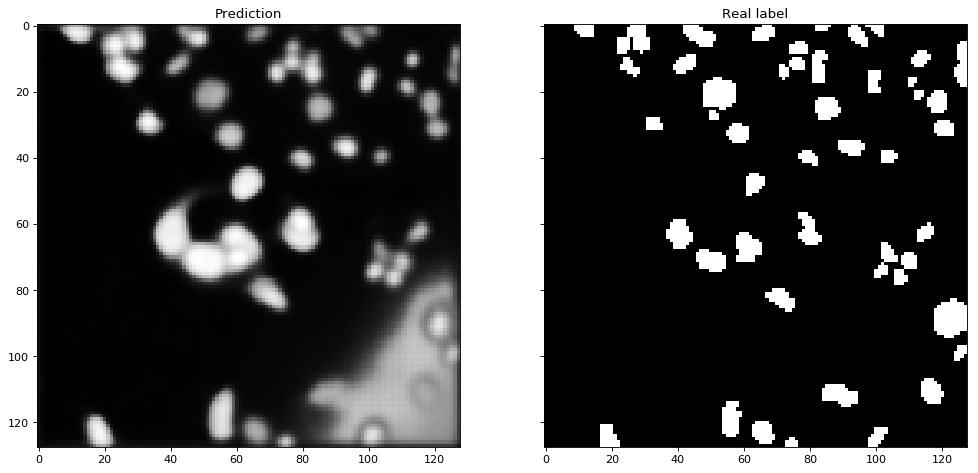

Network evaluation at epoch:  0 
train_avg_loss =  0.4799234040920734 , train_avg_f1_score =  0.33948591662237576 
val_avg_loss =  0.4754401464293252 , val_avg_f1_score =  0.34196505629195806
epoch: 1, train loss: 0.21482146342298877


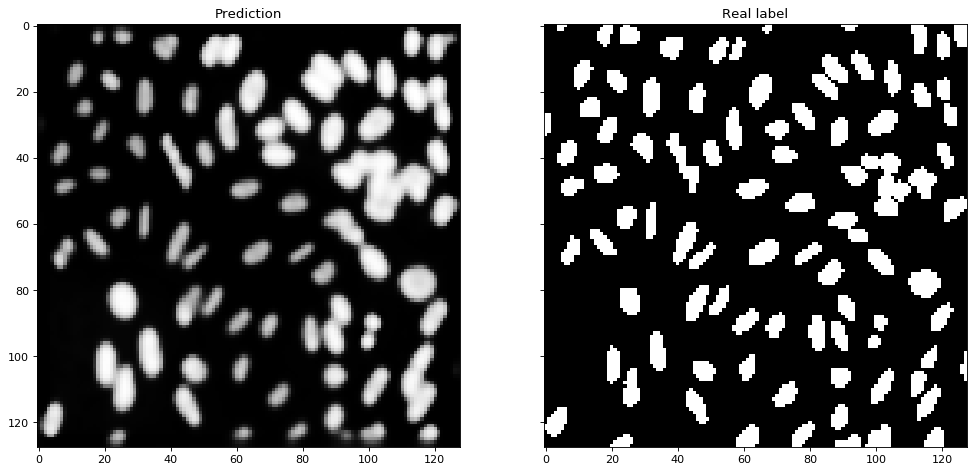

epoch: 2, train loss: 0.16763533407182835


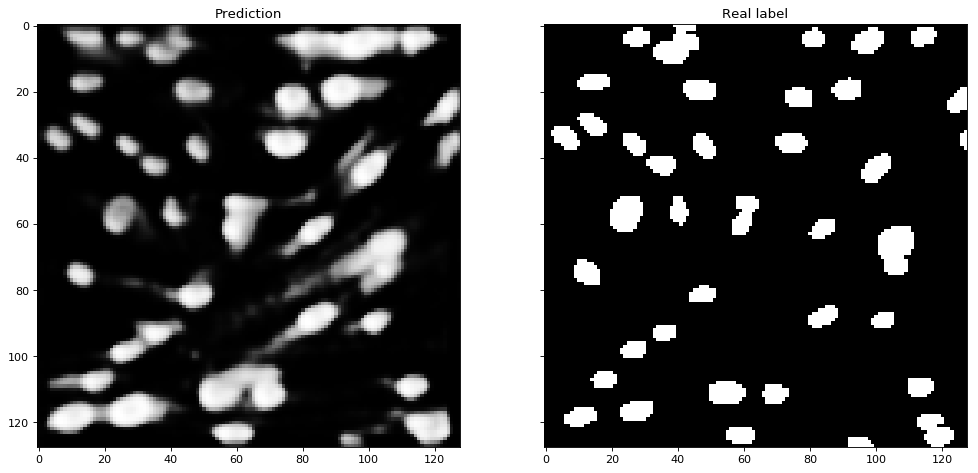

epoch: 3, train loss: 0.13764850873110898


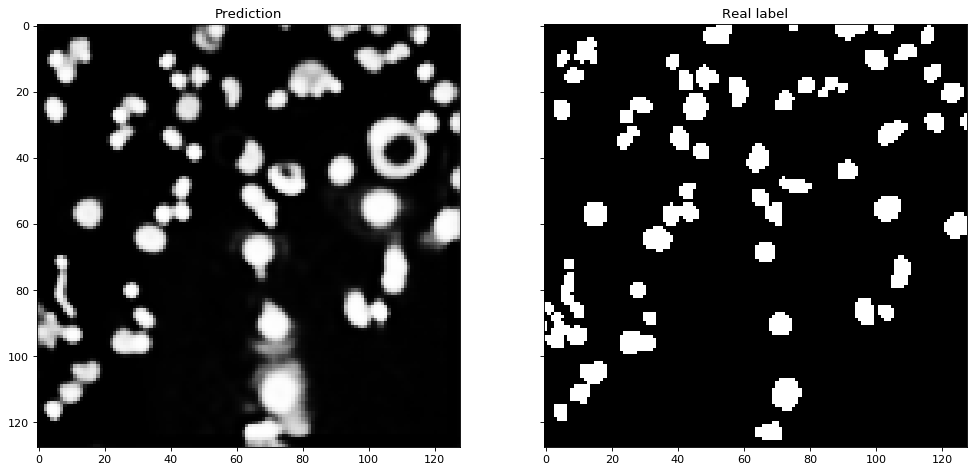

epoch: 4, train loss: 0.13136409690131


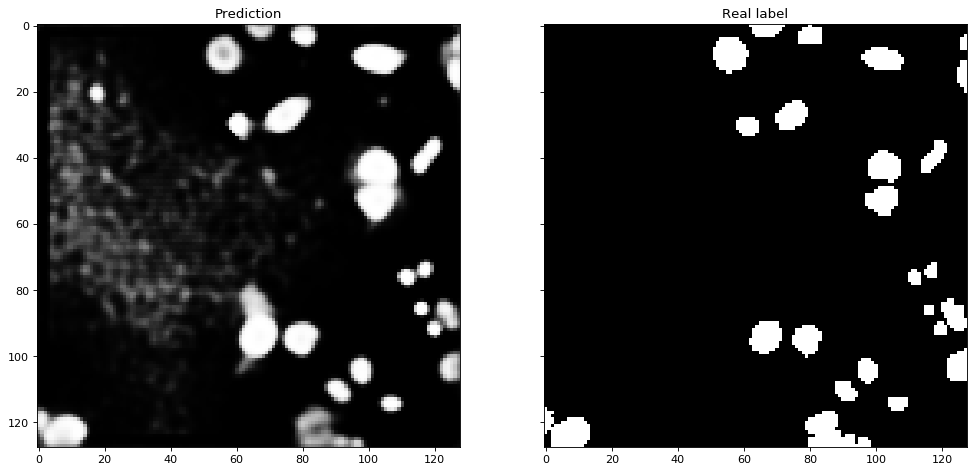

epoch: 5, train loss: 0.12648980230537812


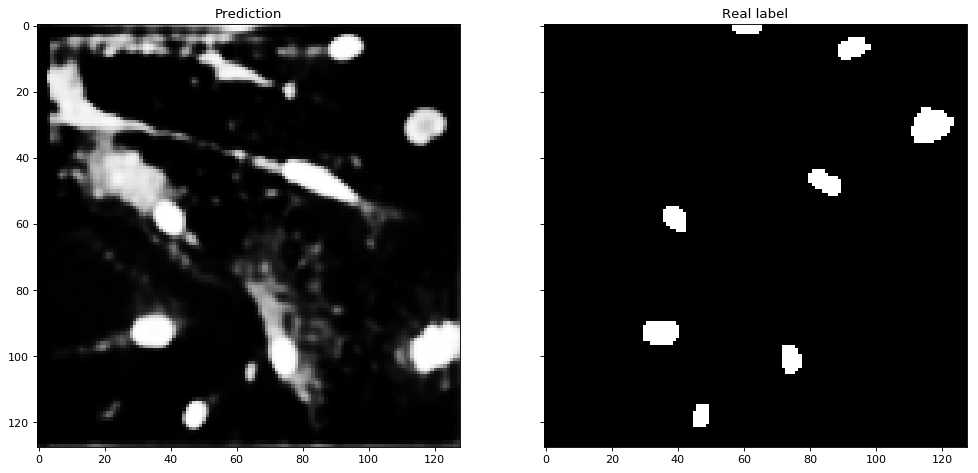

epoch: 6, train loss: 0.11400919835736502


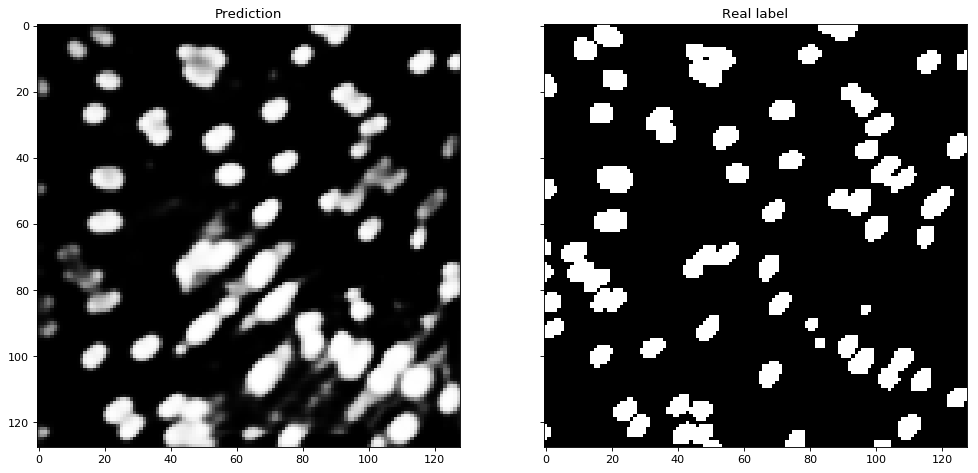

epoch: 7, train loss: 0.10633764554982755


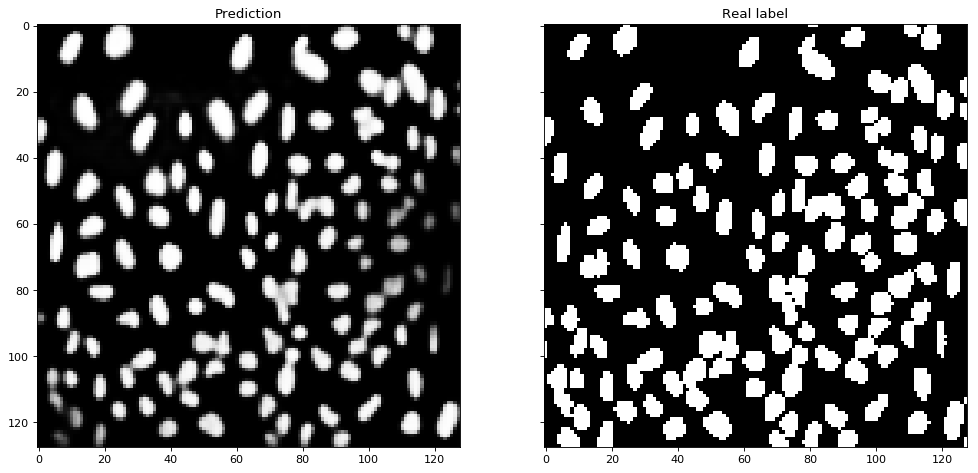

epoch: 8, train loss: 0.10702932398043462


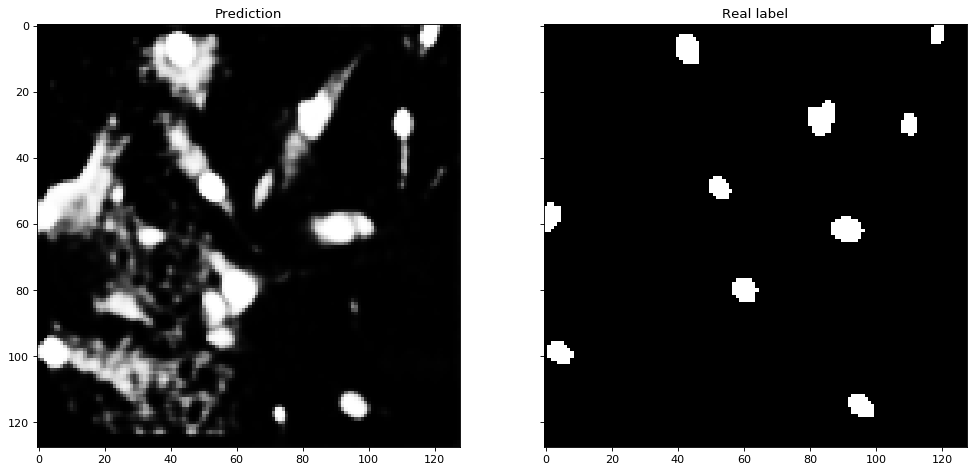

epoch: 9, train loss: 0.09735392312060541


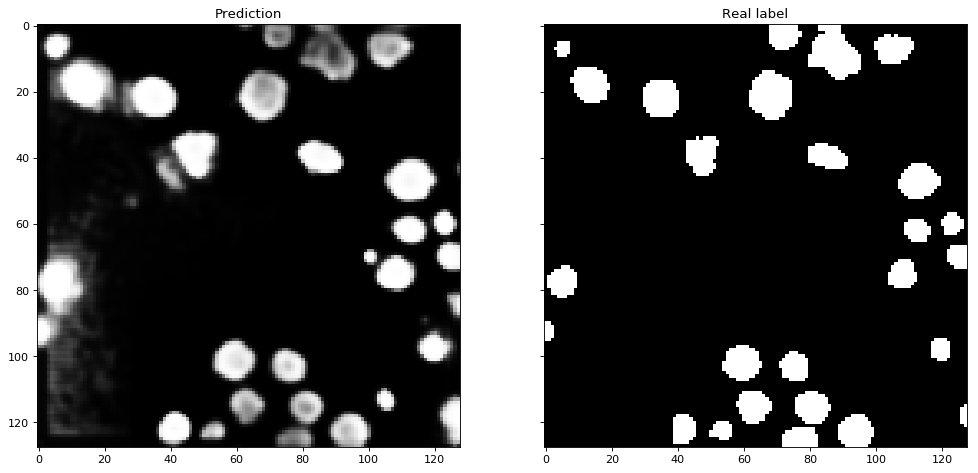

epoch: 10, train loss: 0.09559463754073898


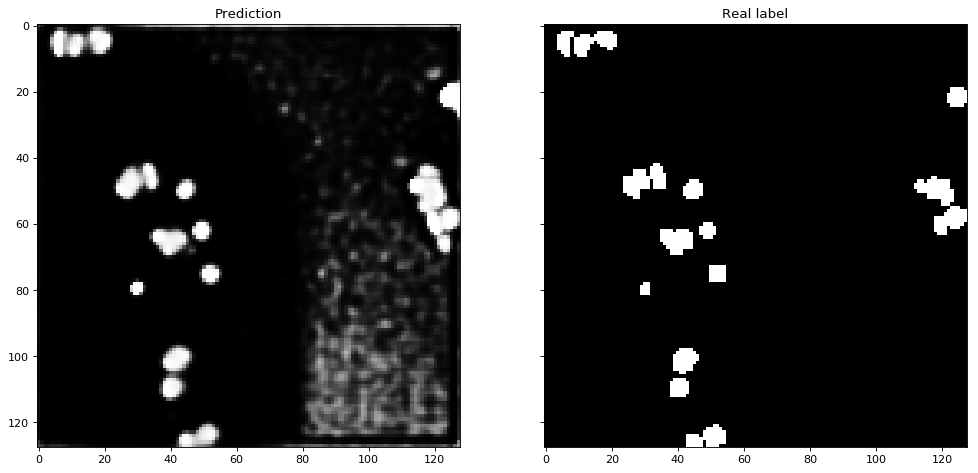

Network evaluation at epoch:  10 
train_avg_loss =  0.37713025897337776 , train_avg_f1_score =  0.6320416242203152 
val_avg_loss =  0.3452239310222942 , val_avg_f1_score =  0.6557880714864518
epoch: 11, train loss: 0.09676765100057445


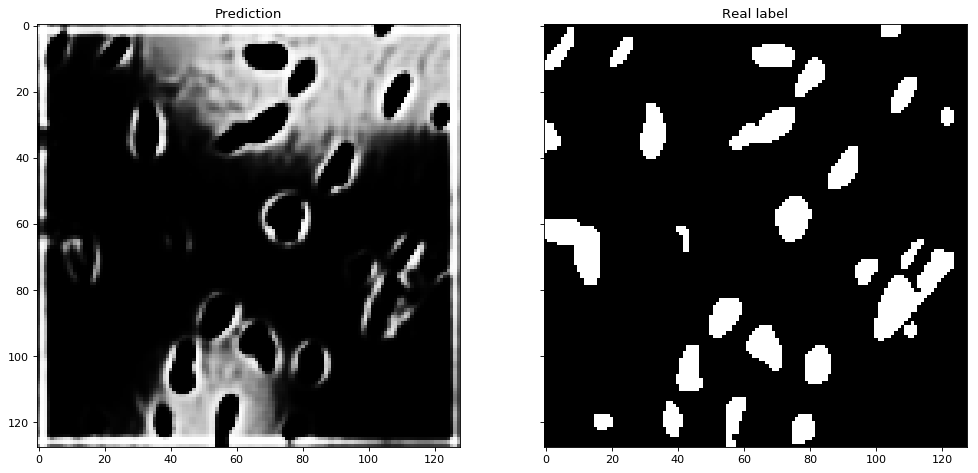

epoch: 12, train loss: 0.08908429830821592


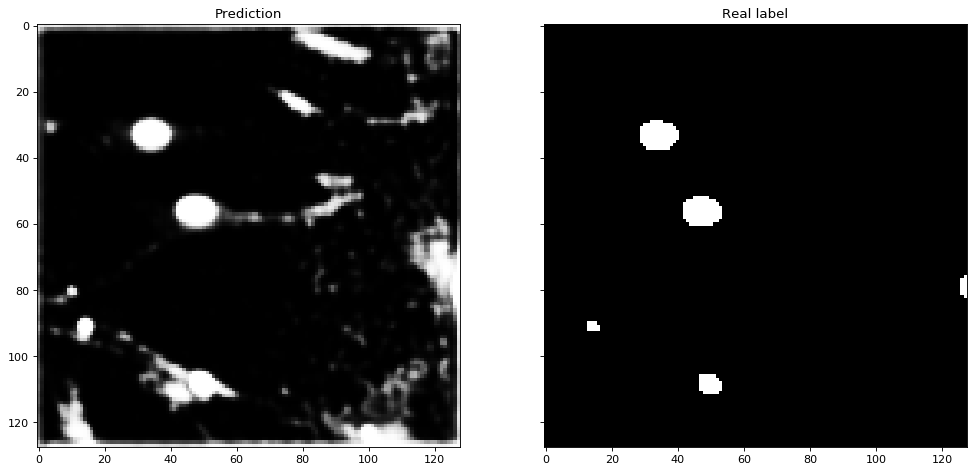

epoch: 13, train loss: 0.08897021207124439


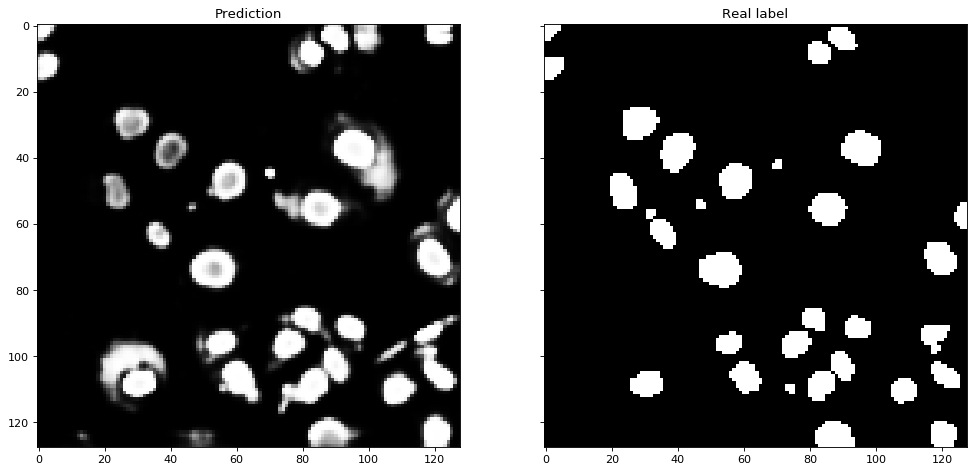

epoch: 14, train loss: 0.08245043145186866


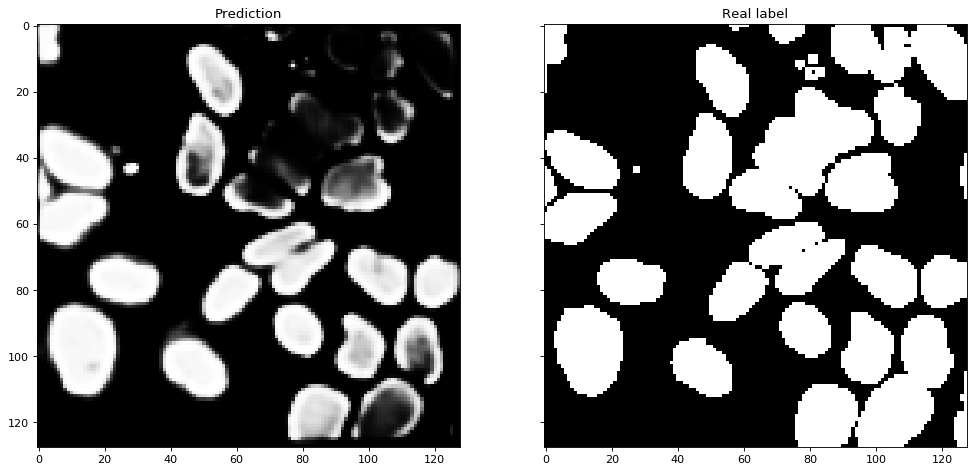

epoch: 15, train loss: 0.08364213230227356


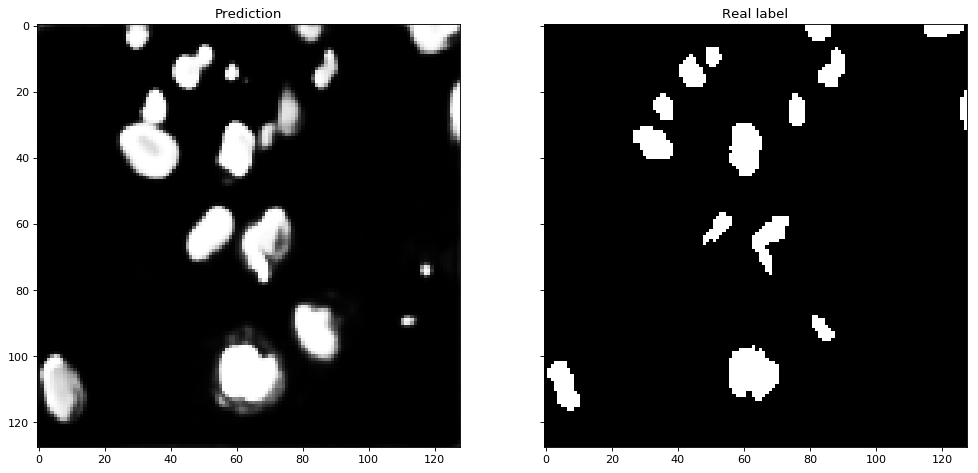

epoch: 16, train loss: 0.0794930521454384


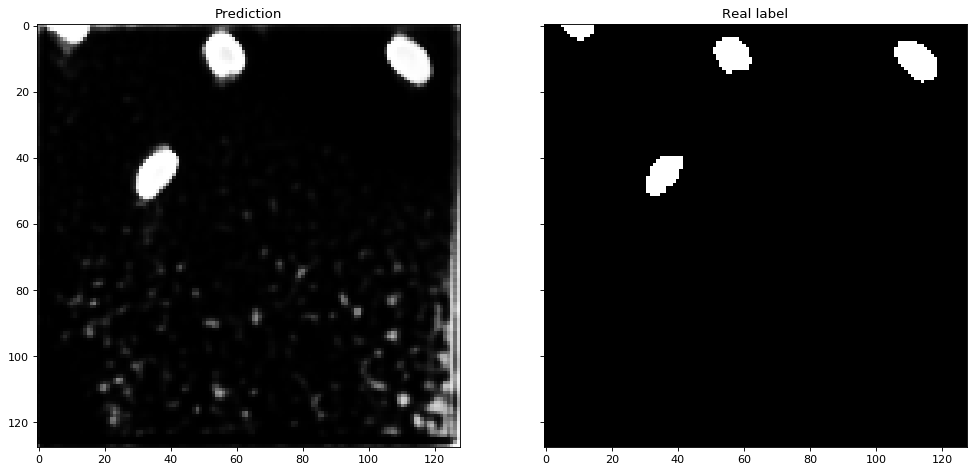

epoch: 17, train loss: 0.08132245046878929


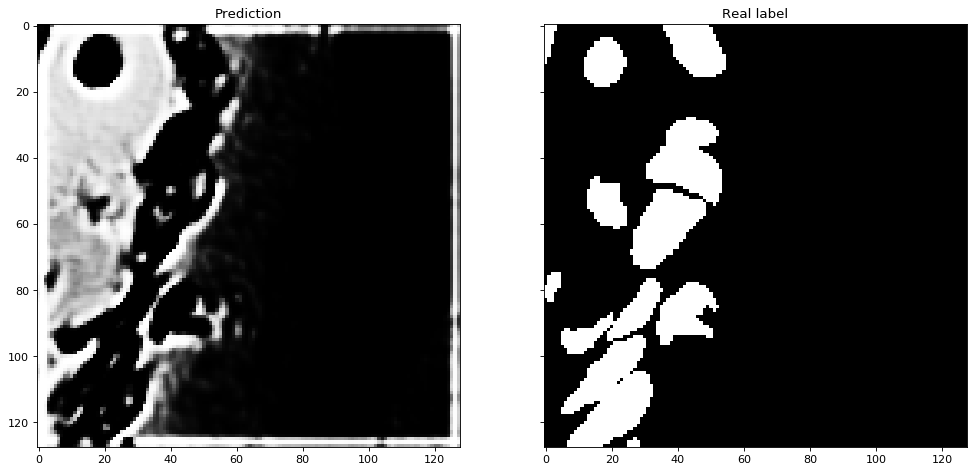

epoch: 18, train loss: 0.07931930121423593


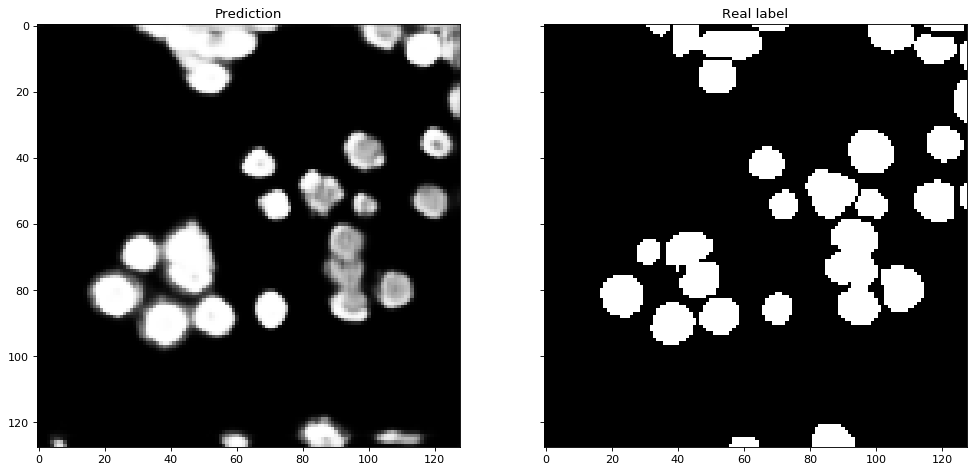

epoch: 19, train loss: 0.07674326914459911


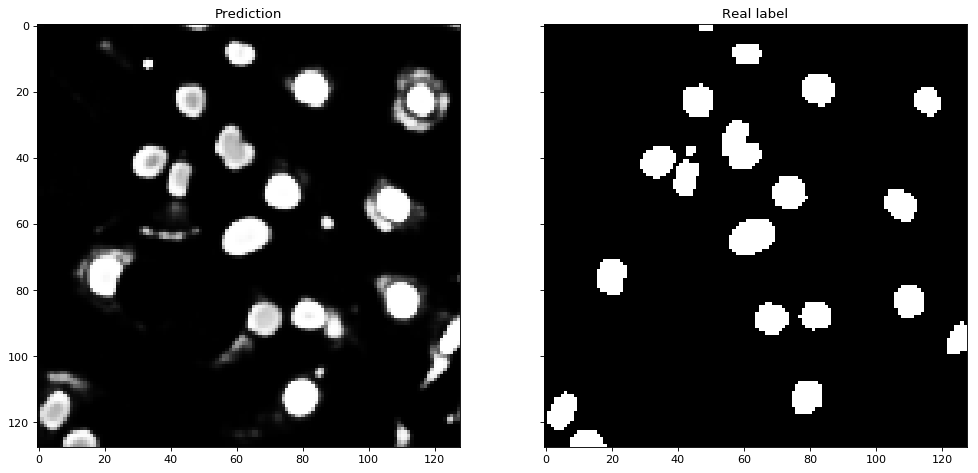

epoch: 20, train loss: 0.07436253947775755


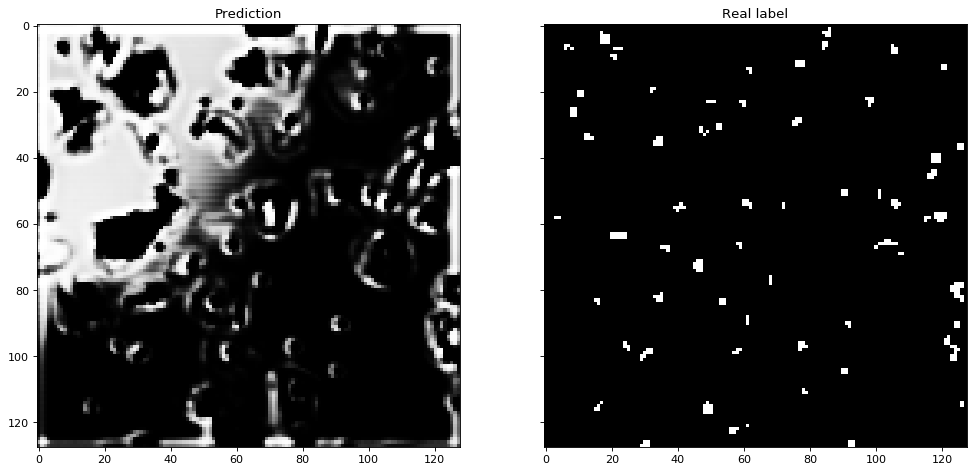

Network evaluation at epoch:  20 
train_avg_loss =  0.4379044388223343 , train_avg_f1_score =  0.7123082050540412 
val_avg_loss =  0.38900496002022567 , val_avg_f1_score =  0.7363653602070757
epoch: 21, train loss: 0.07144699557058846


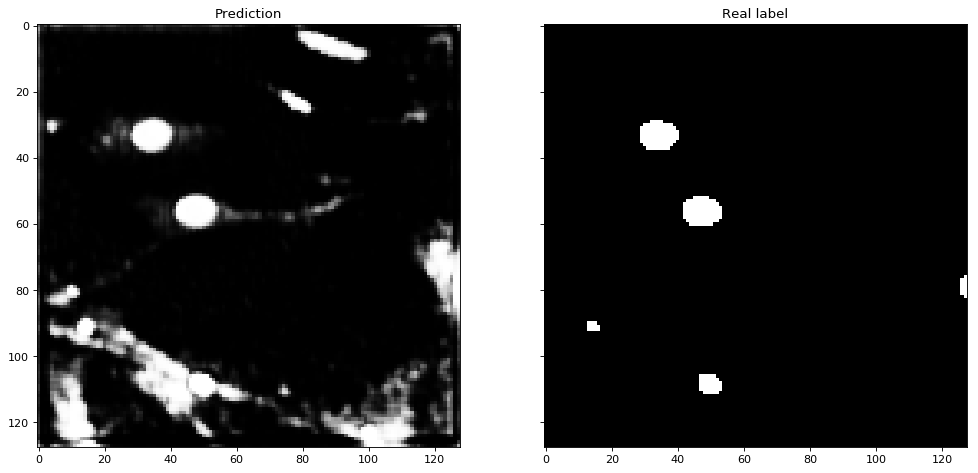

epoch: 22, train loss: 0.07311866788276986


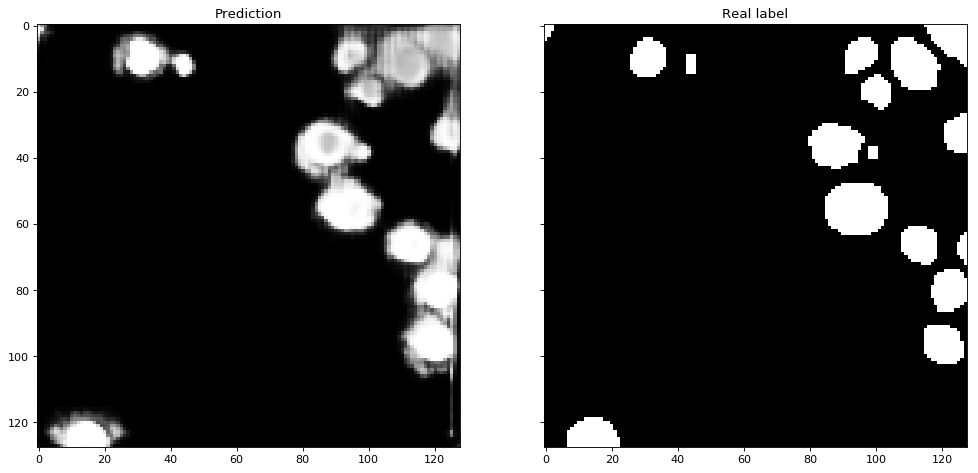

epoch: 23, train loss: 0.07009642493368974


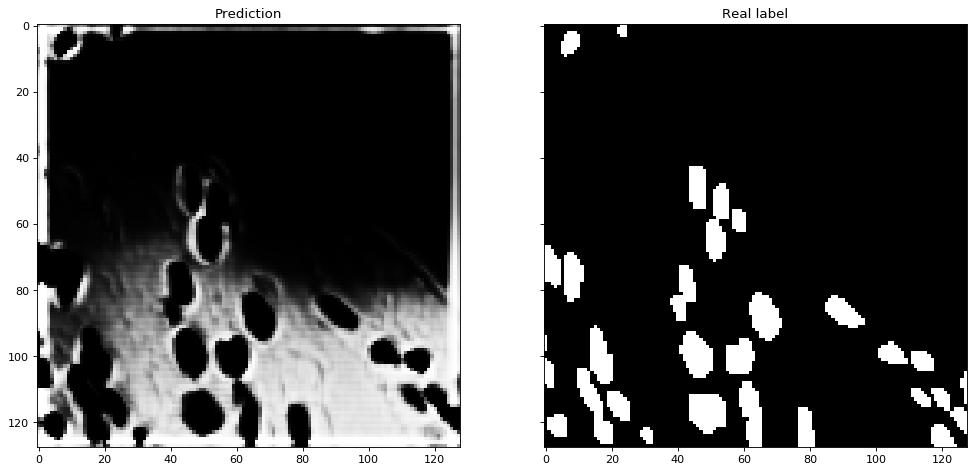

epoch: 24, train loss: 0.06945573154892494


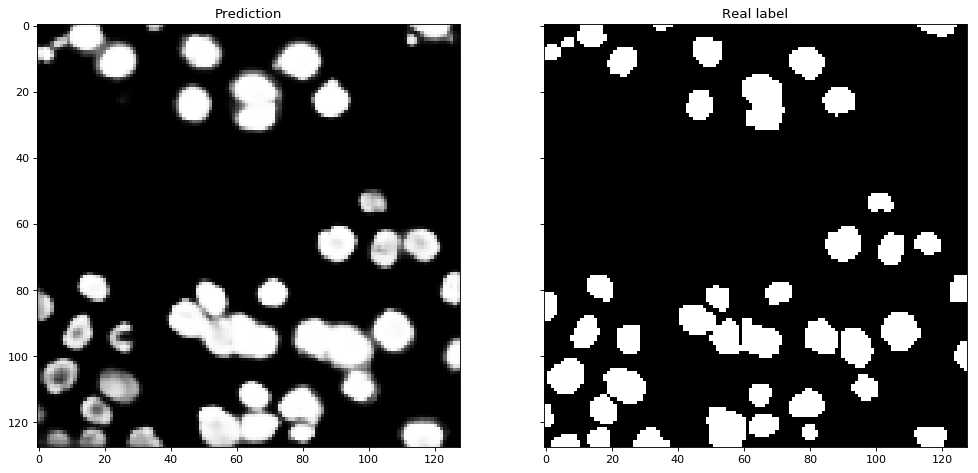

epoch: 25, train loss: 0.06898075097532415


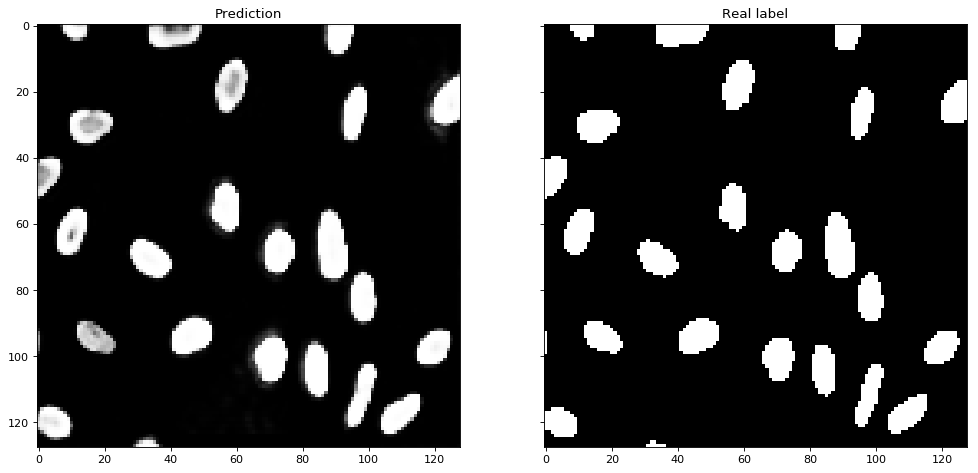

epoch: 26, train loss: 0.07853922514773126


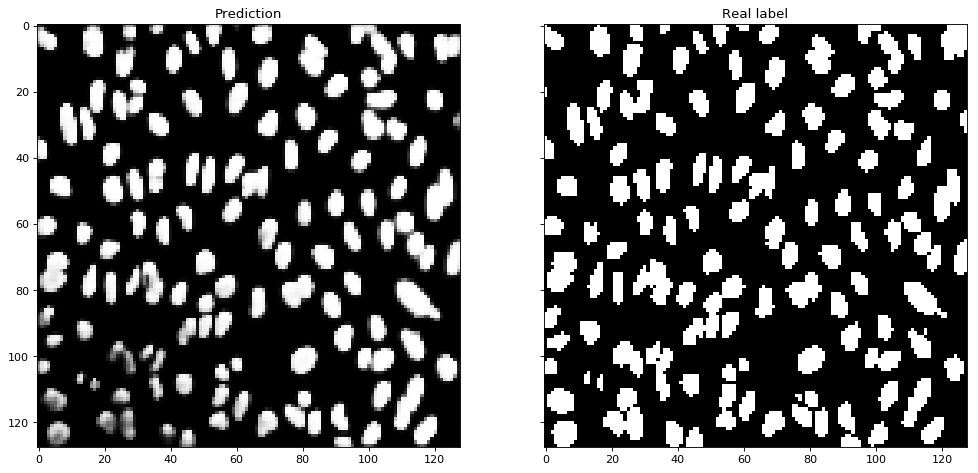

epoch: 27, train loss: 0.08825960093692167


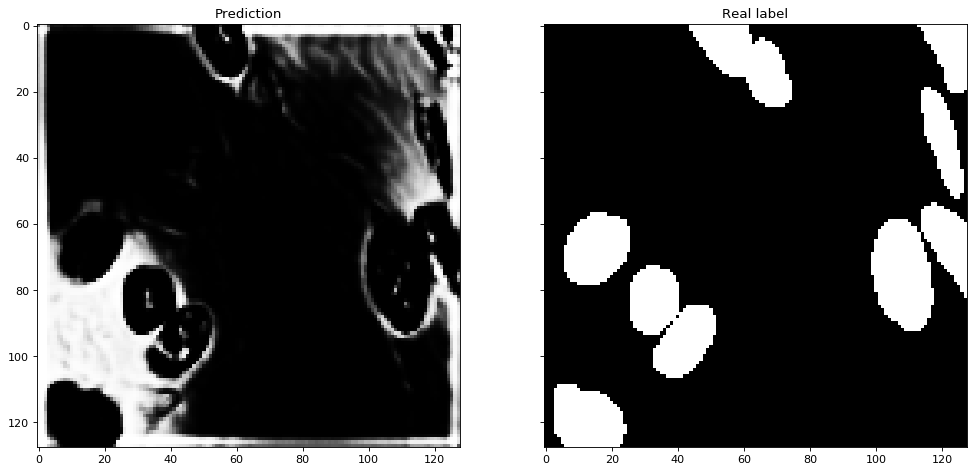

epoch: 28, train loss: 0.07290368871902352


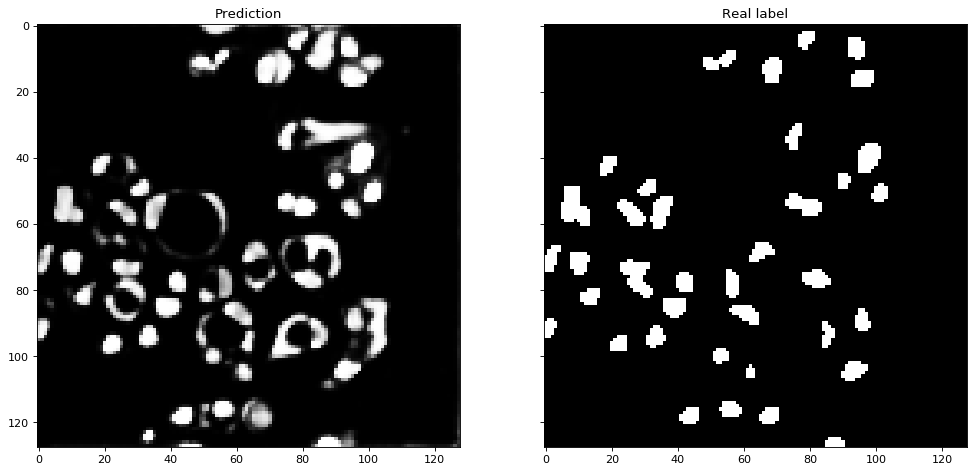

epoch: 29, train loss: 0.07115469750628542


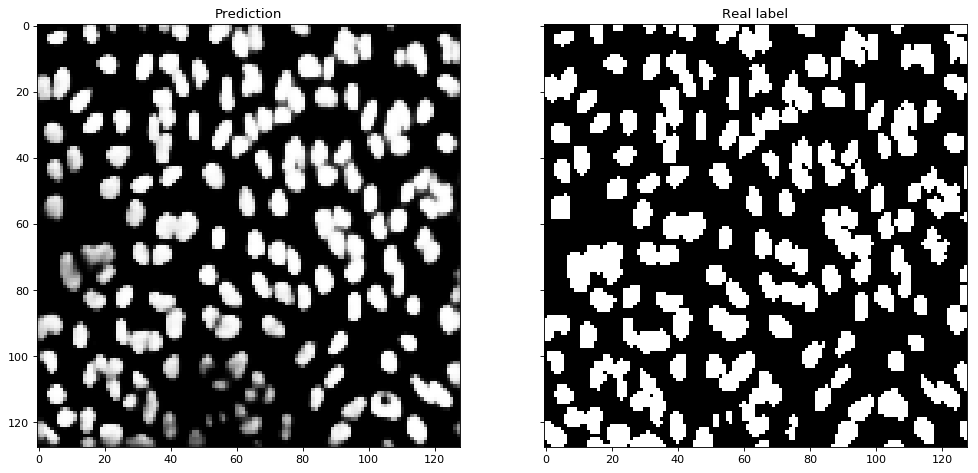

epoch: 30, train loss: 0.07106496349199494


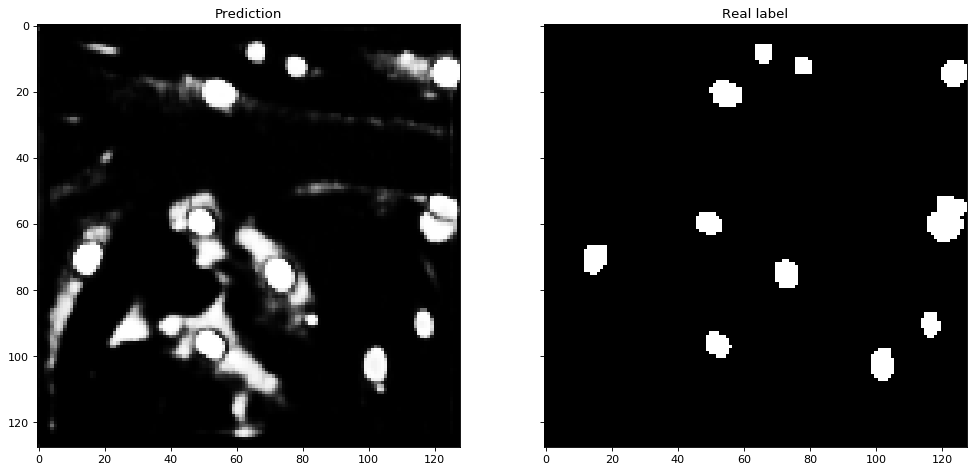

Network evaluation at epoch:  30 
train_avg_loss =  0.10149189121465728 , train_avg_f1_score =  0.877343589470449 
val_avg_loss =  0.09885368429805472 , val_avg_f1_score =  0.8829820712830678
epoch: 31, train loss: 0.06821068987917545


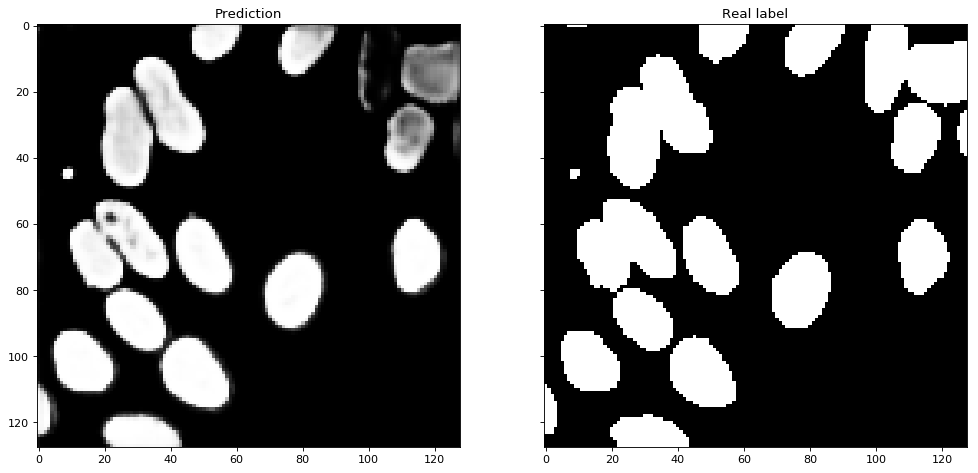

epoch: 32, train loss: 0.06707260251712444


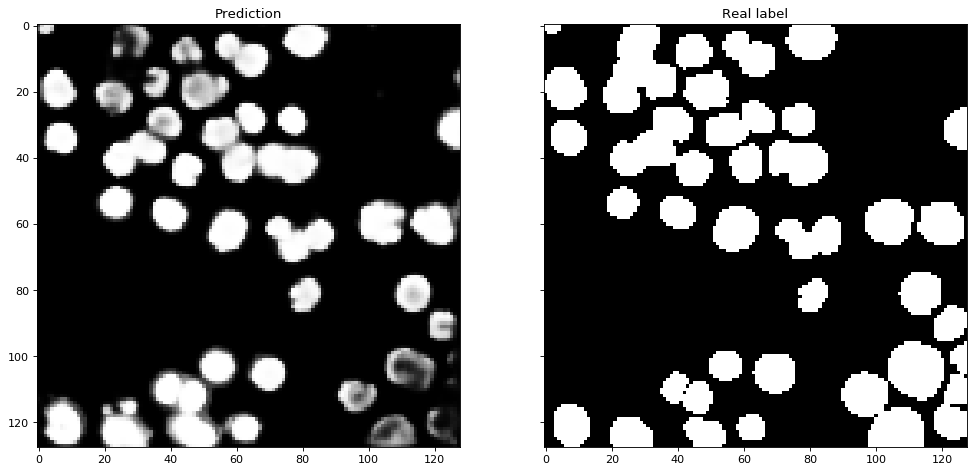

epoch: 33, train loss: 0.06563561693278712


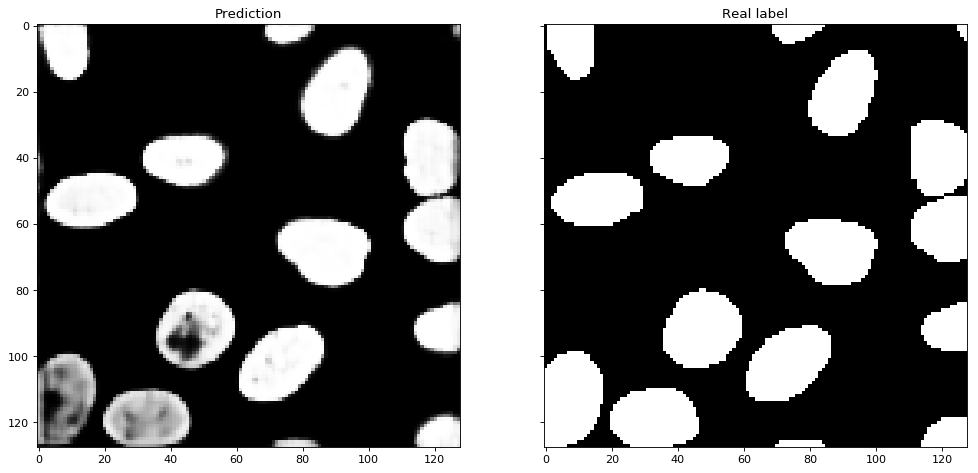

epoch: 34, train loss: 0.06565936677046676


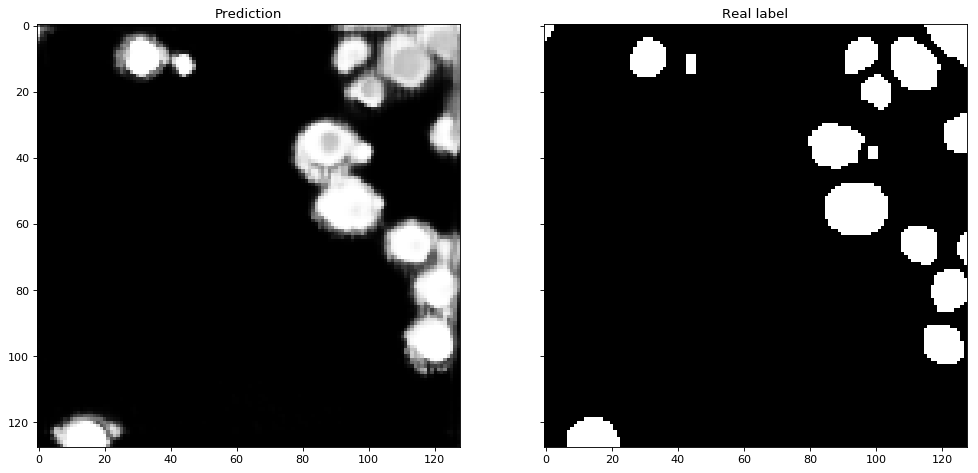

epoch: 35, train loss: 0.06660434592570831


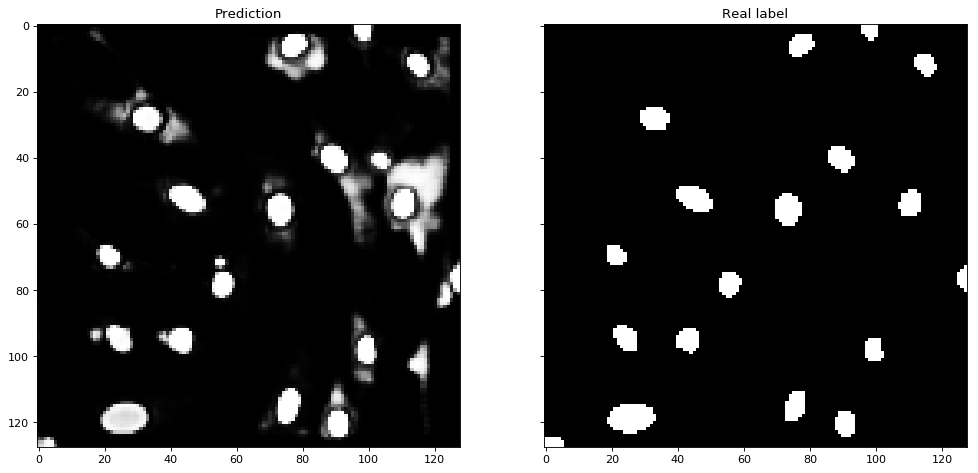

epoch: 36, train loss: 0.06501040818975933


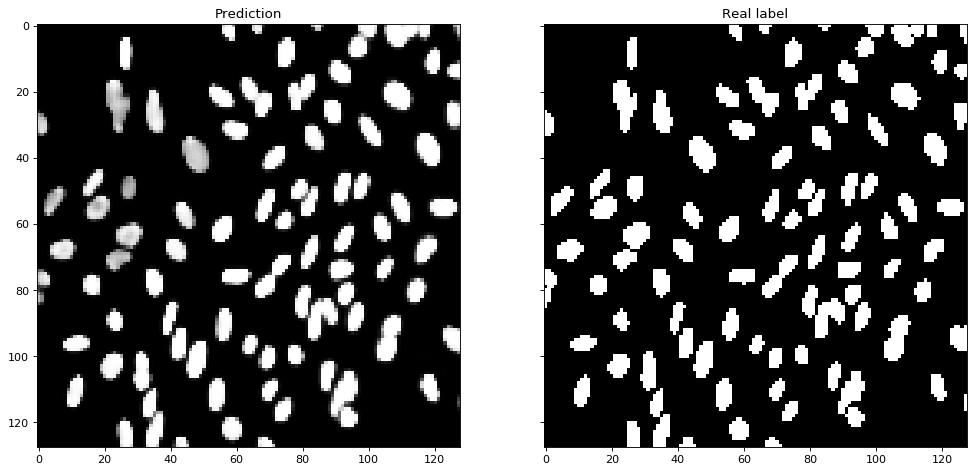

epoch: 37, train loss: 0.06471754919125963


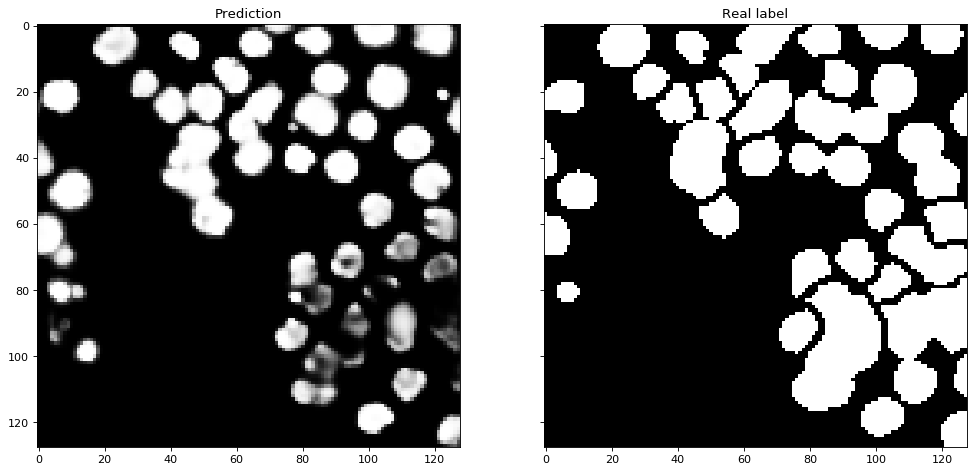

epoch: 38, train loss: 0.06296601349404499


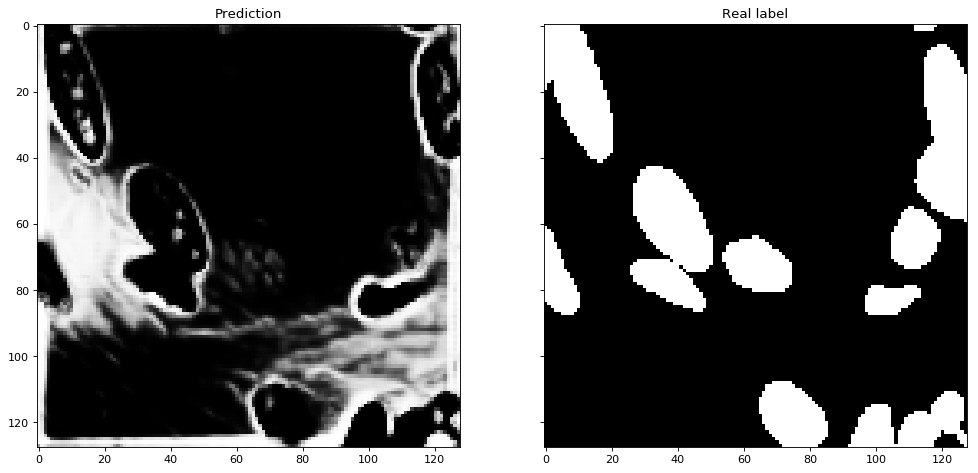

epoch: 39, train loss: 0.06268575031365921


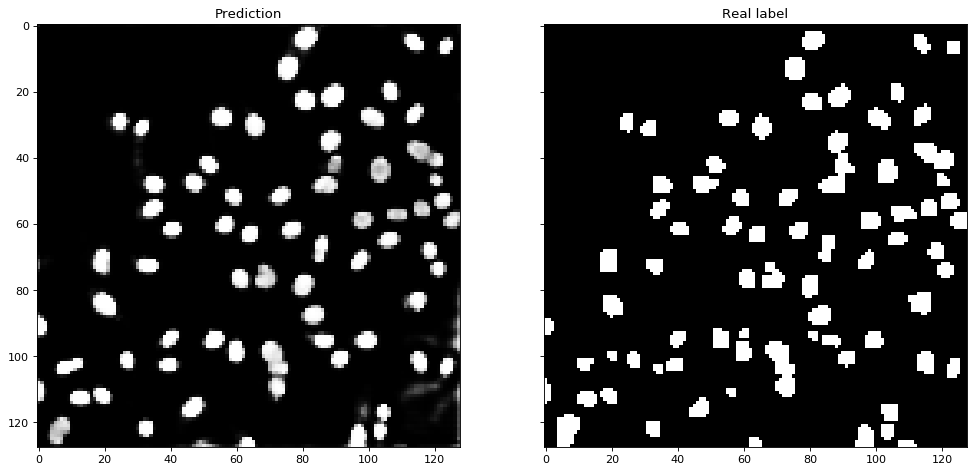

epoch: 40, train loss: 0.06271016875754541


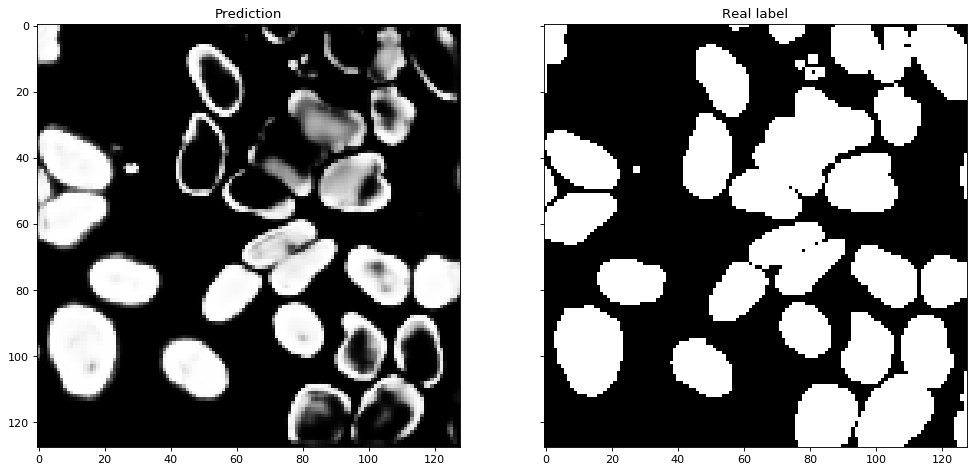

Network evaluation at epoch:  40 
train_avg_loss =  0.16159900703355357 , train_avg_f1_score =  0.8079152410517256 
val_avg_loss =  0.15211652908057197 , val_avg_f1_score =  0.828431032296674
epoch: 41, train loss: 0.06219510342091767


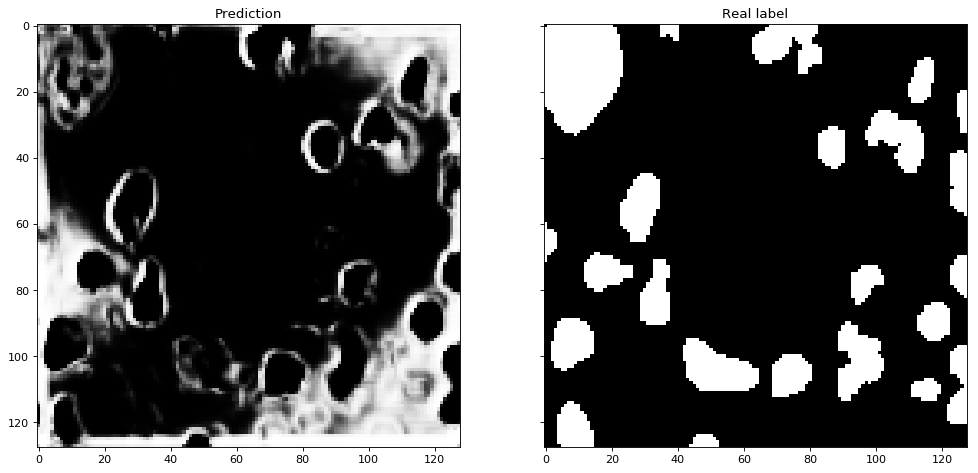

epoch: 42, train loss: 0.061913757737892774


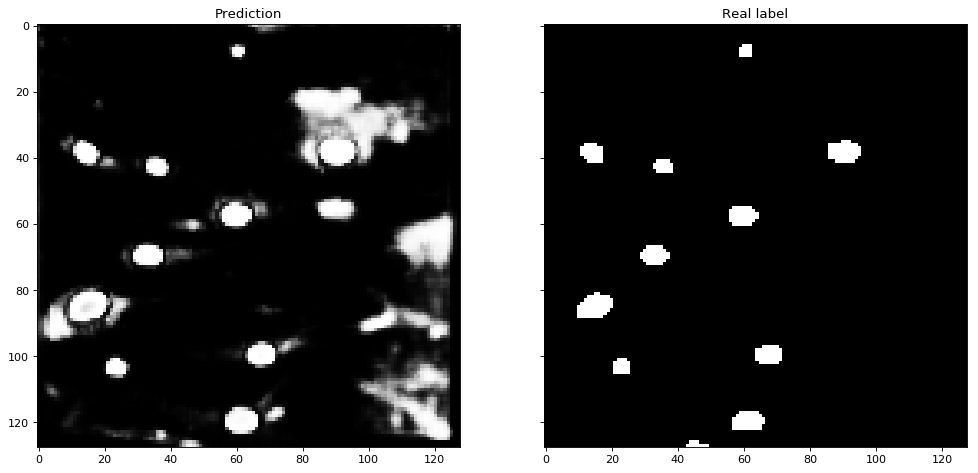

epoch: 43, train loss: 0.06165343106015405


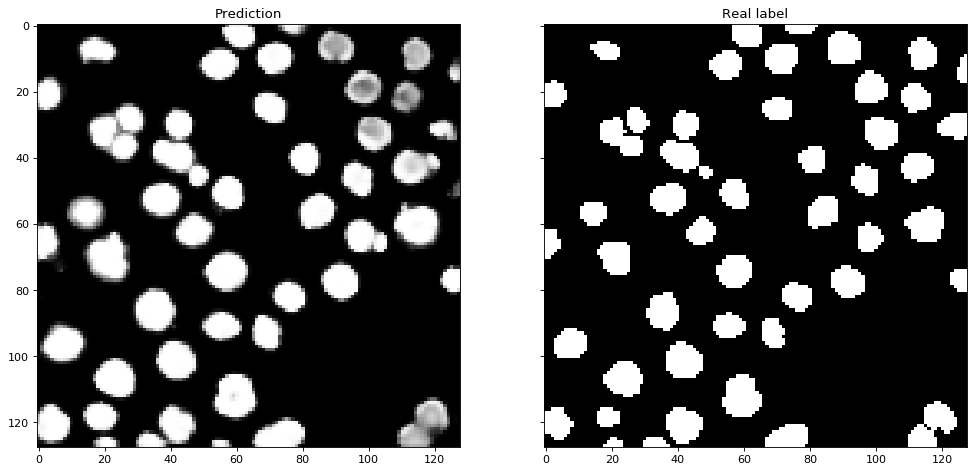

epoch: 44, train loss: 0.06142504115714066


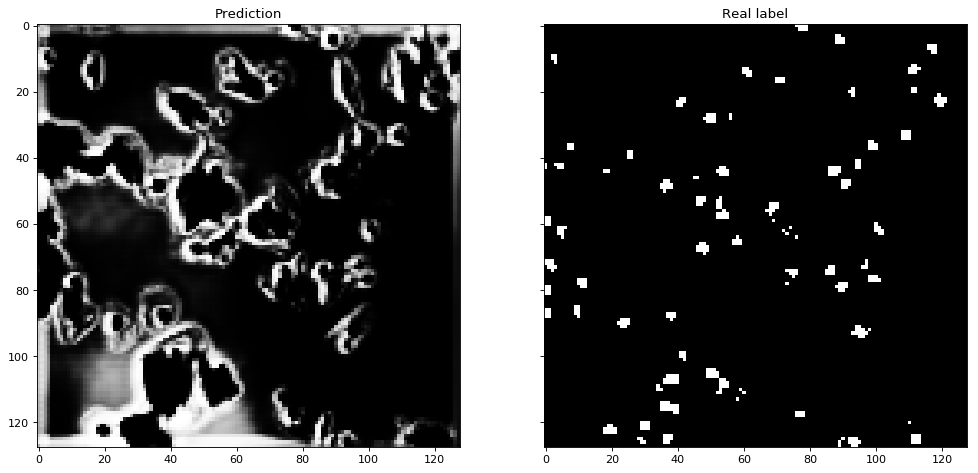

epoch: 45, train loss: 0.0674045955512061


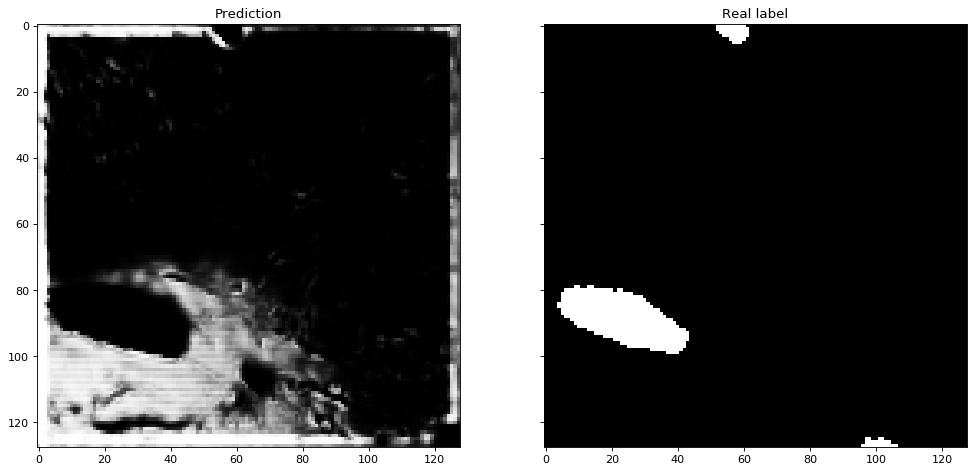

epoch: 46, train loss: 0.0667715418472219


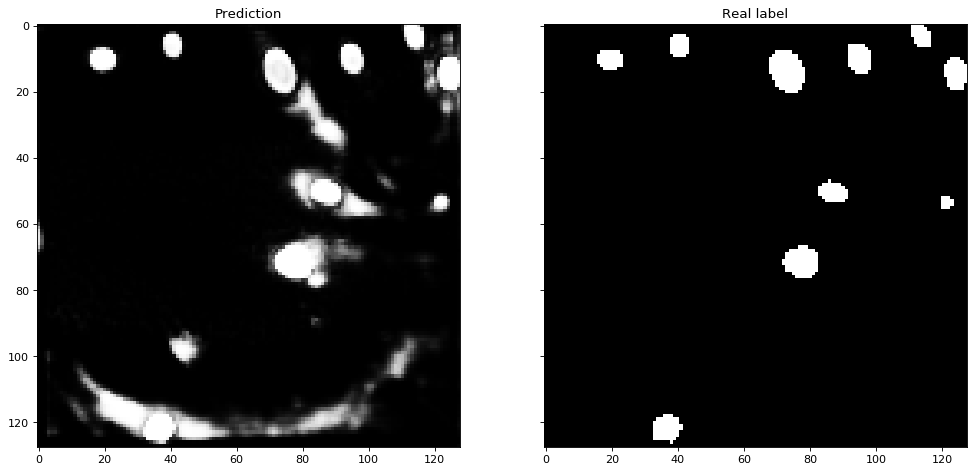

epoch: 47, train loss: 0.0720027438573428


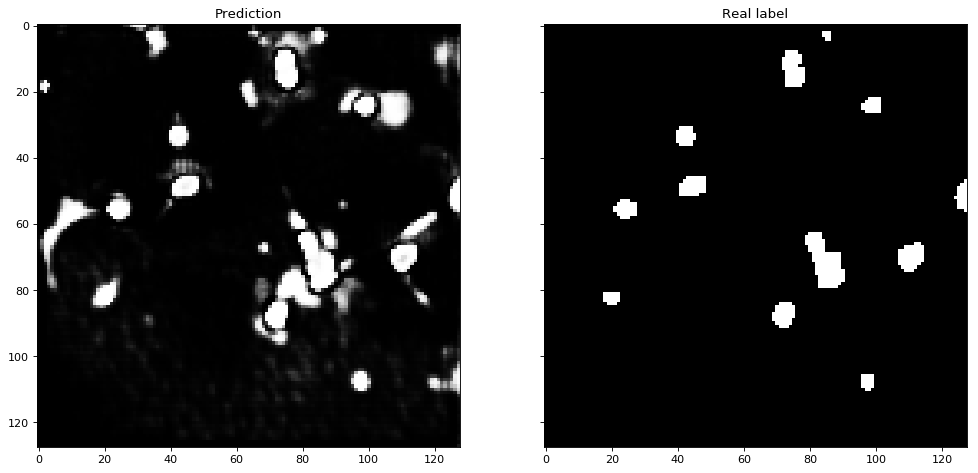

epoch: 48, train loss: 0.06761433840242785


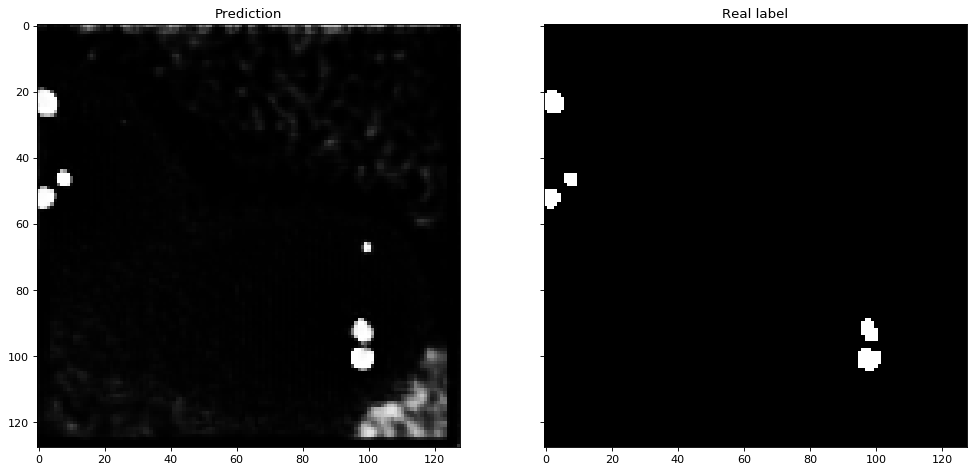

epoch: 49, train loss: 0.06340019613393207


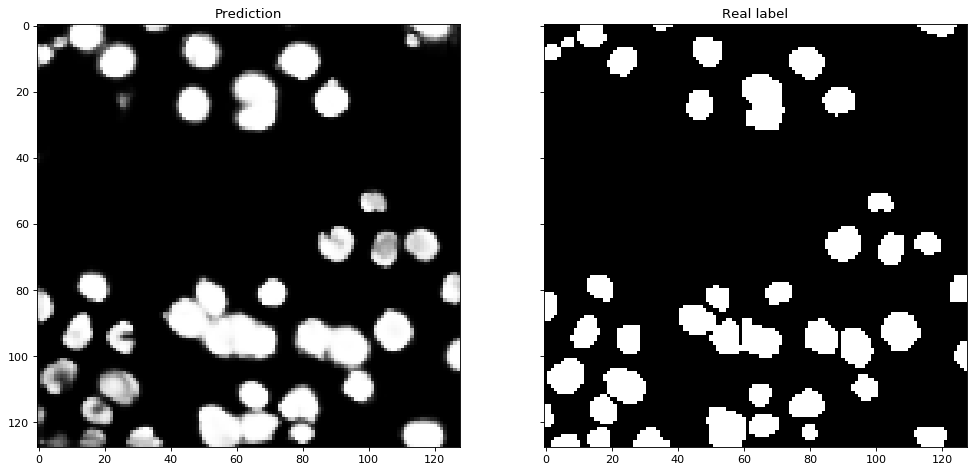

epoch: 50, train loss: 0.062154516077308514


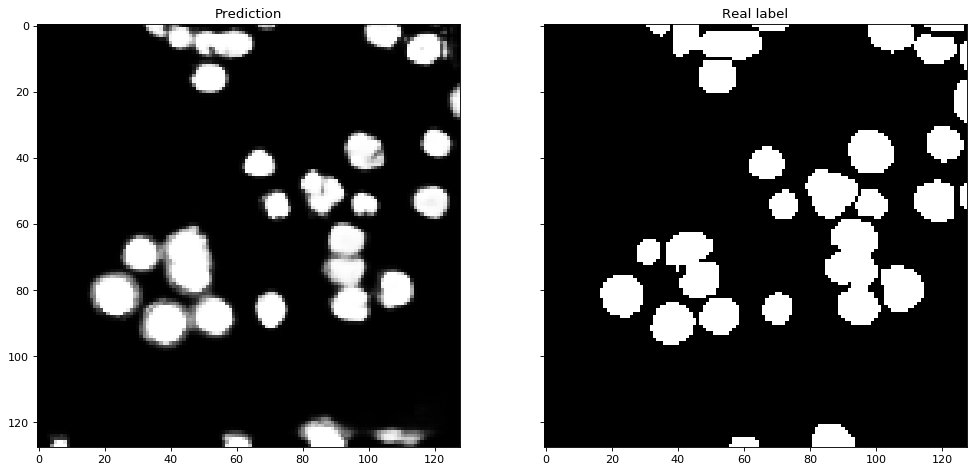

Network evaluation at epoch:  50 
train_avg_loss =  0.07077789572772349 , train_avg_f1_score =  0.901477559501975 
val_avg_loss =  0.06944968742874465 , val_avg_f1_score =  0.9040091711472569
epoch: 51, train loss: 0.060740359071920165


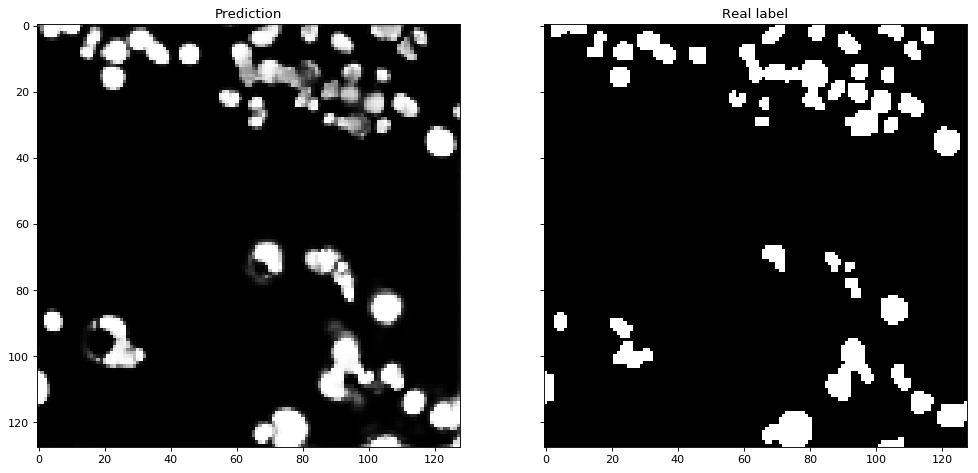

epoch: 52, train loss: 0.060685009264679096


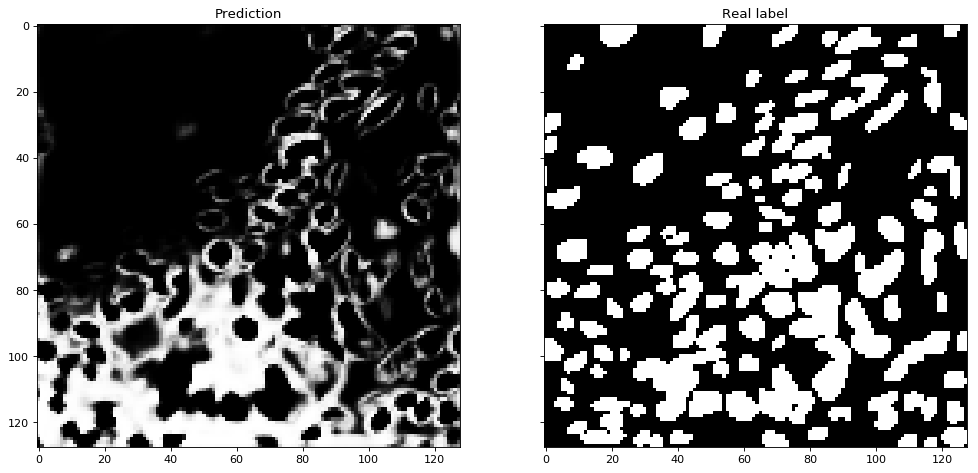

epoch: 53, train loss: 0.060612145338707894


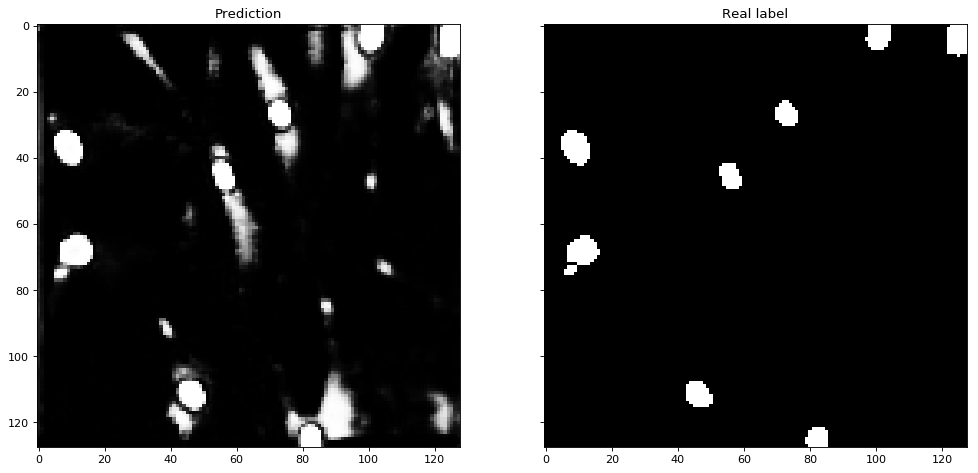

epoch: 54, train loss: 0.058895579997950524


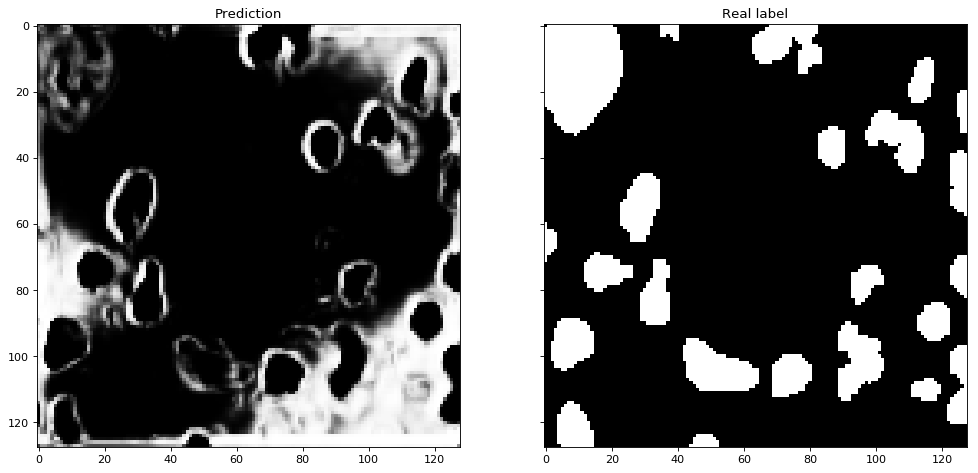

epoch: 55, train loss: 0.059130738392027454


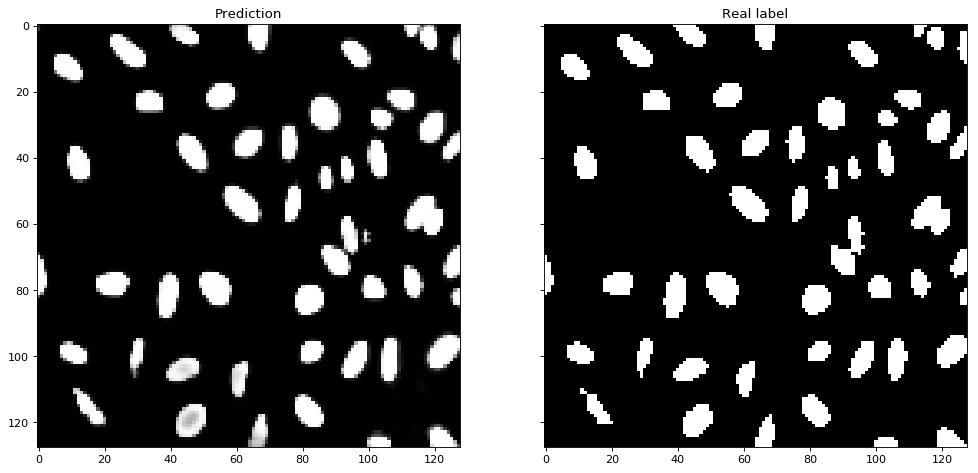

epoch: 56, train loss: 0.05867321972749127


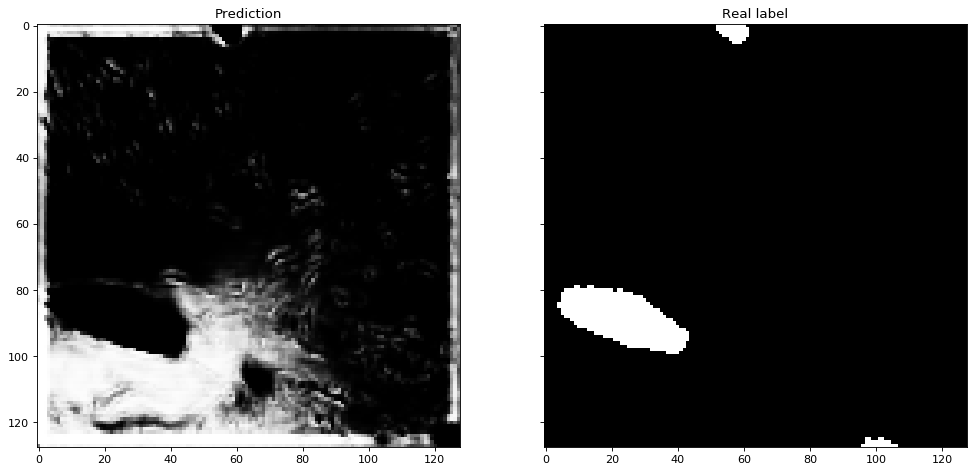

epoch: 57, train loss: 0.058487864739414475


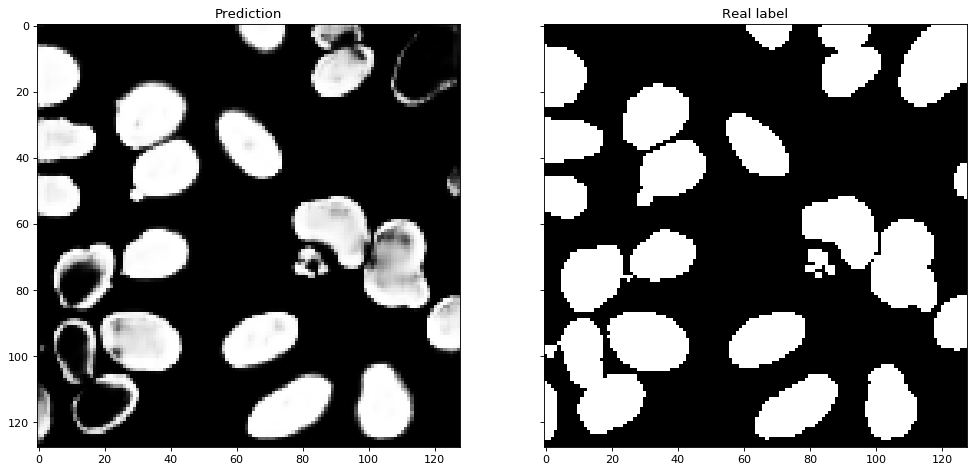

epoch: 58, train loss: 0.05838836226334323


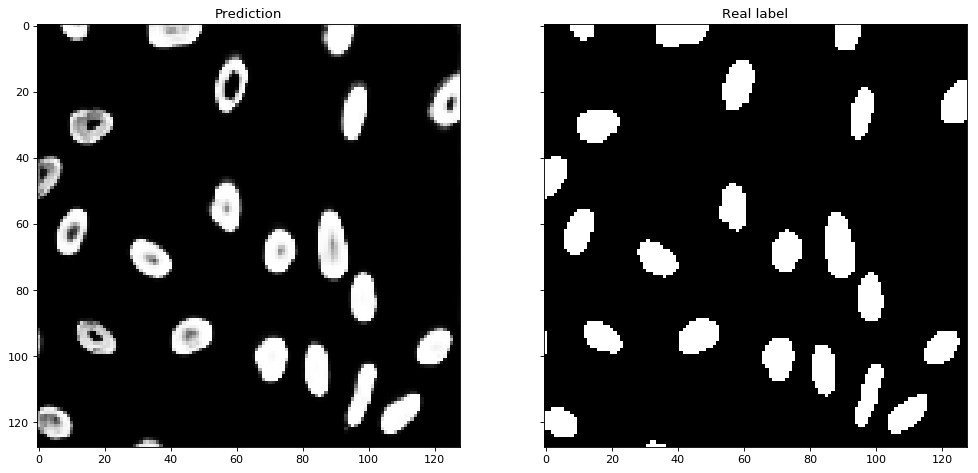

epoch: 59, train loss: 0.06012257736231854


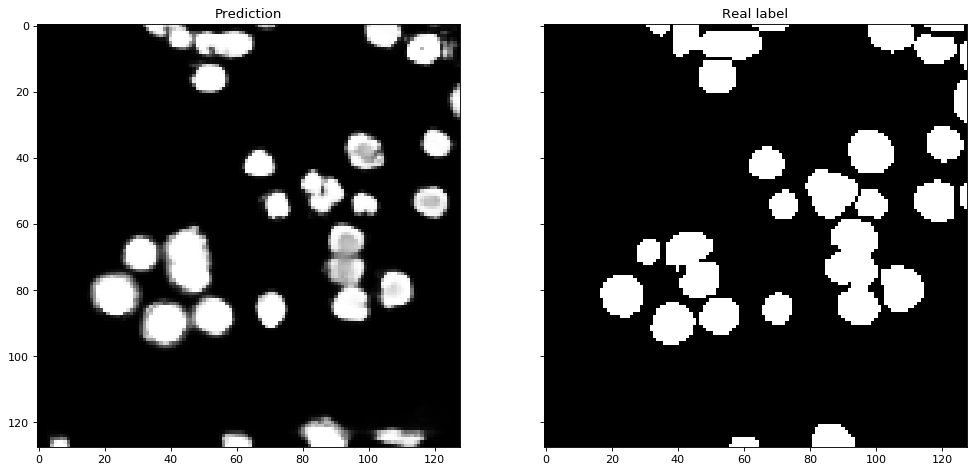

epoch: 60, train loss: 0.058613454923033714


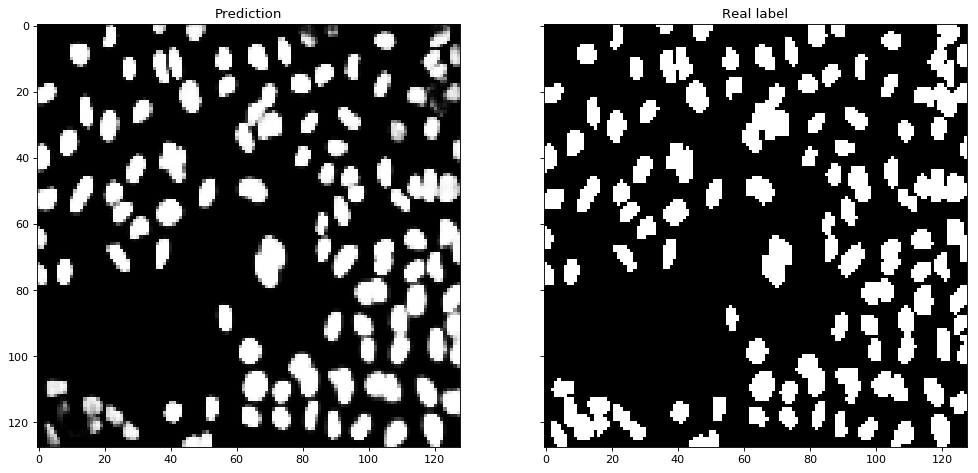

Network evaluation at epoch:  60 
train_avg_loss =  0.08193859180978302 , train_avg_f1_score =  0.8906697378176567 
val_avg_loss =  0.07754435232465169 , val_avg_f1_score =  0.8966730843476155
epoch: 61, train loss: 0.058012298350013904


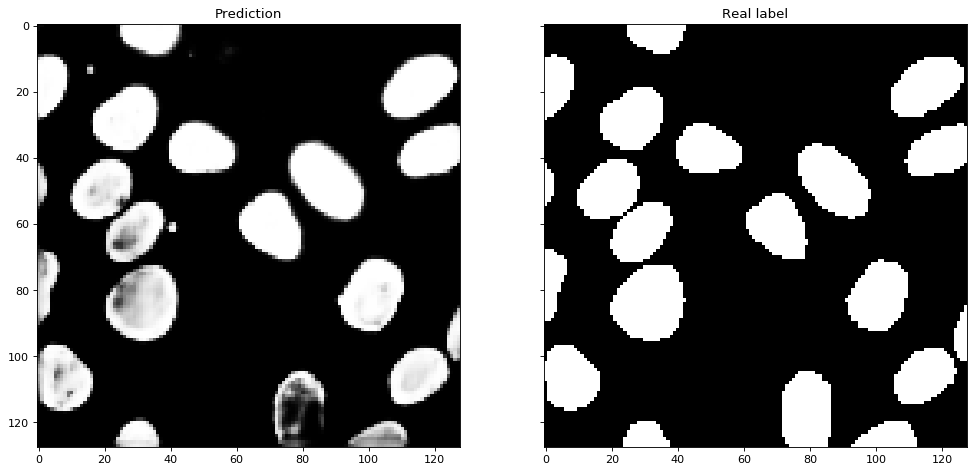

epoch: 62, train loss: 0.05681754062091237


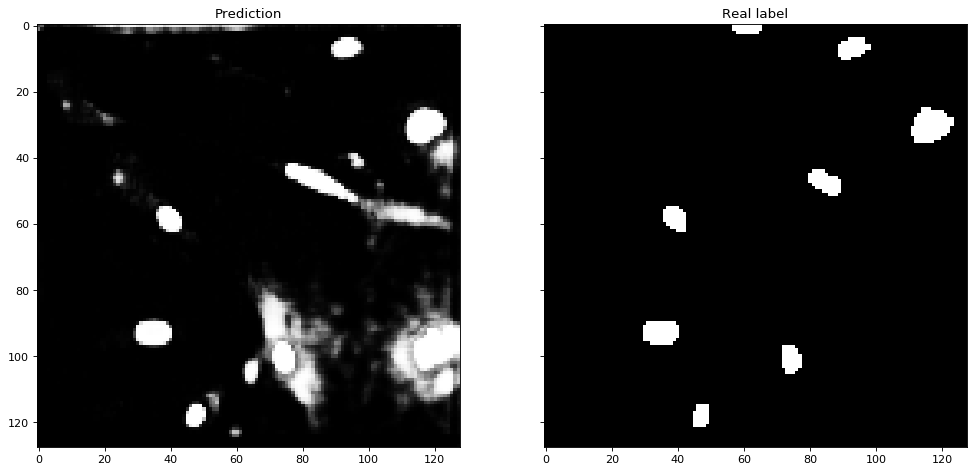

epoch: 63, train loss: 0.056696039443807814


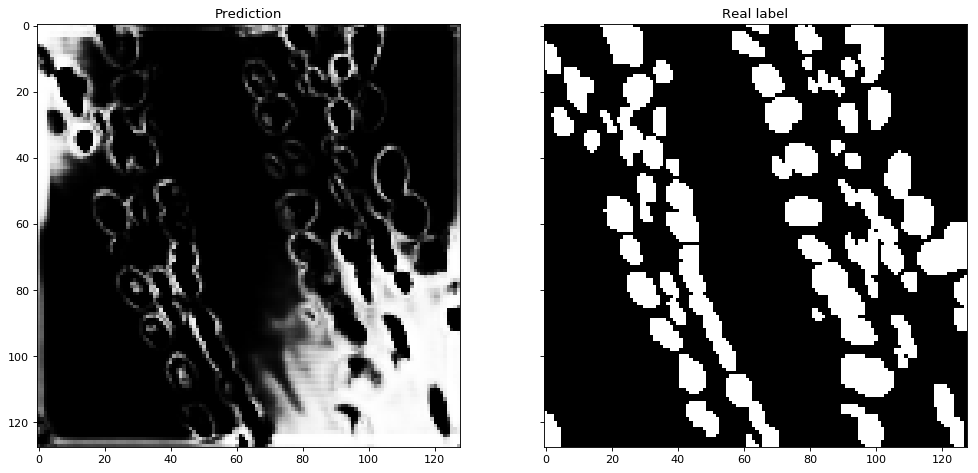

epoch: 64, train loss: 0.05564814130428122


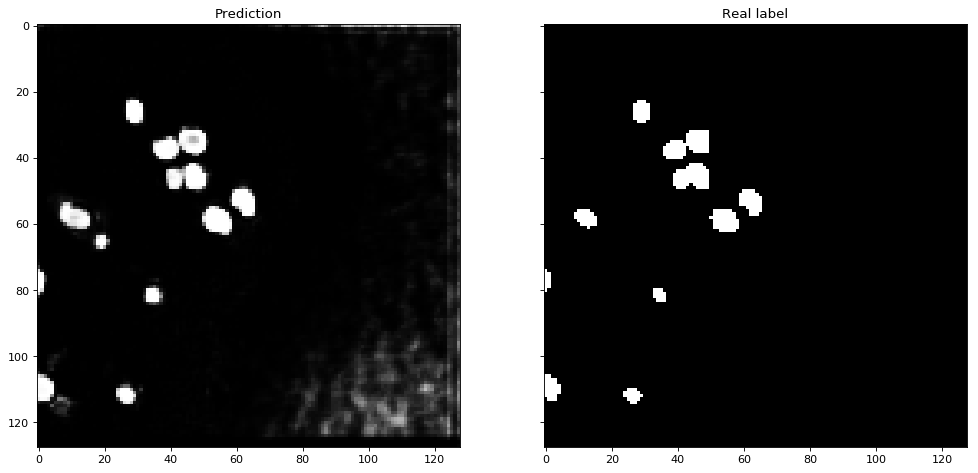

epoch: 65, train loss: 0.05873532265202323


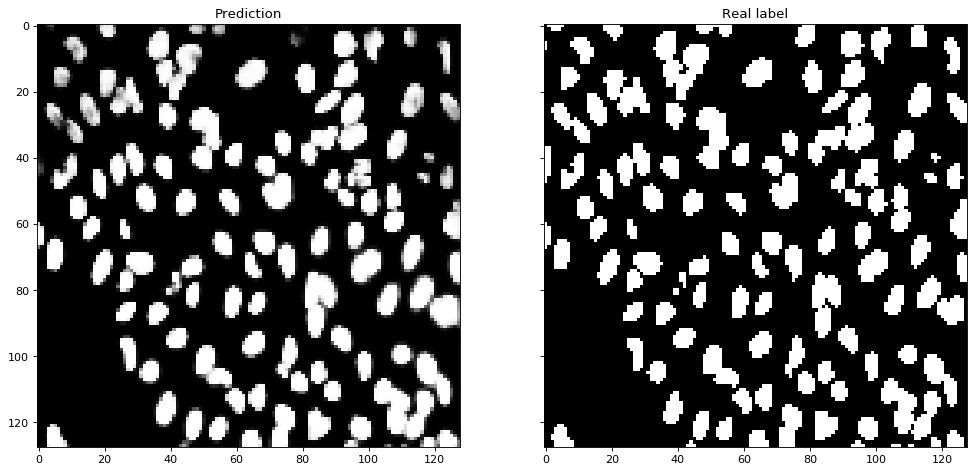

epoch: 66, train loss: 0.05668632057842923


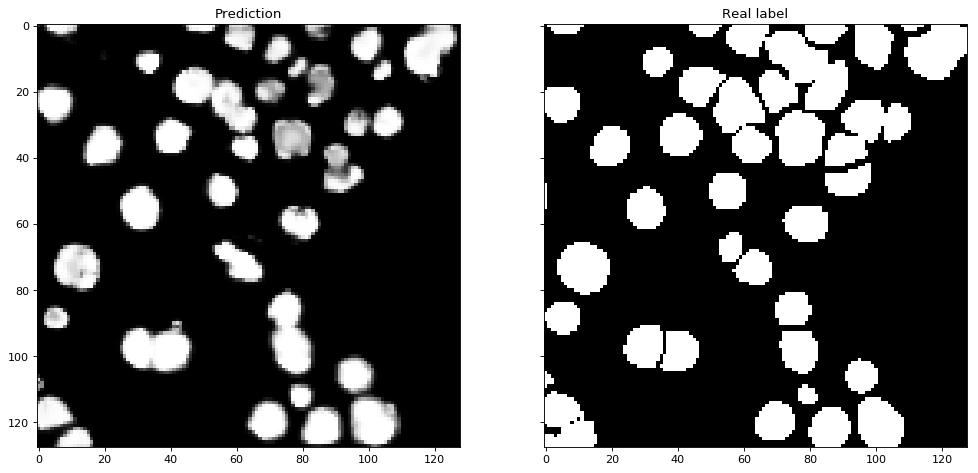

epoch: 67, train loss: 0.0551432392824052


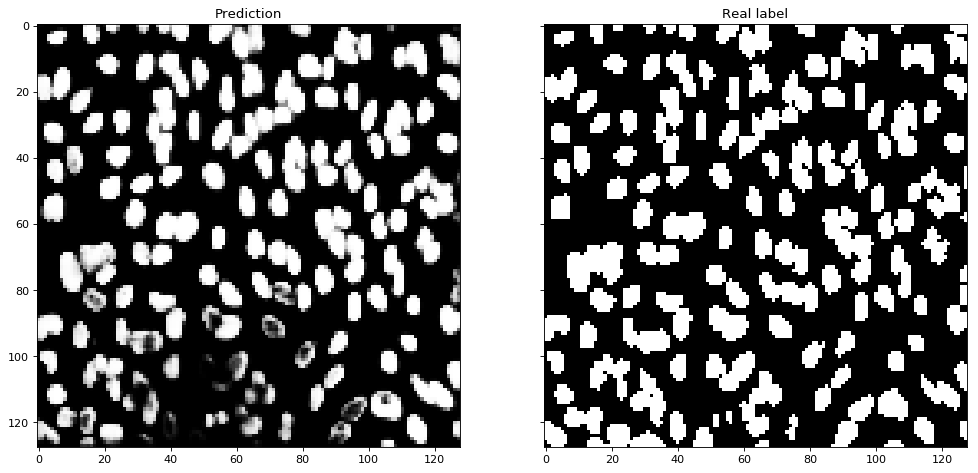

epoch: 68, train loss: 0.0545287945710901


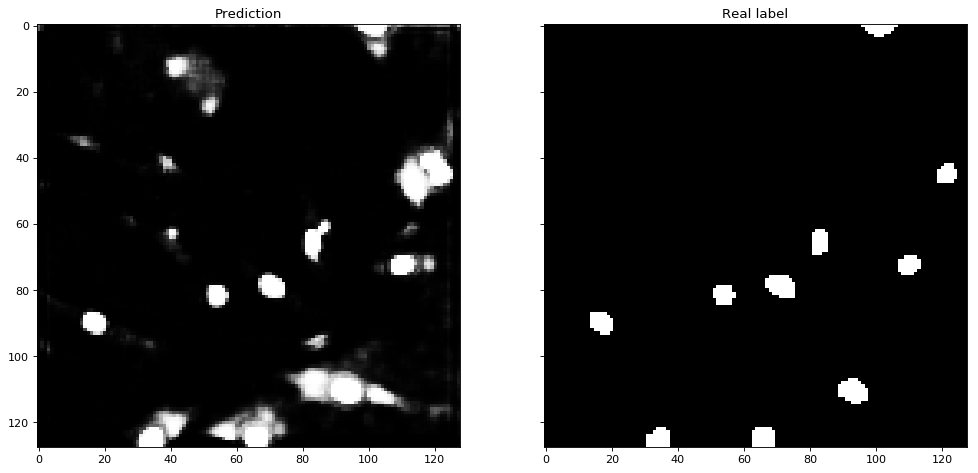

epoch: 69, train loss: 0.054805767680726834


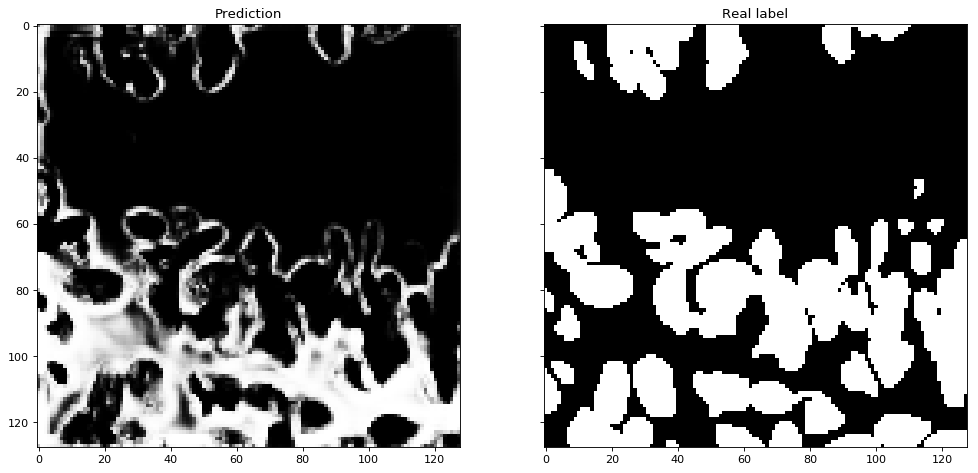

epoch: 70, train loss: 0.05618585373705892


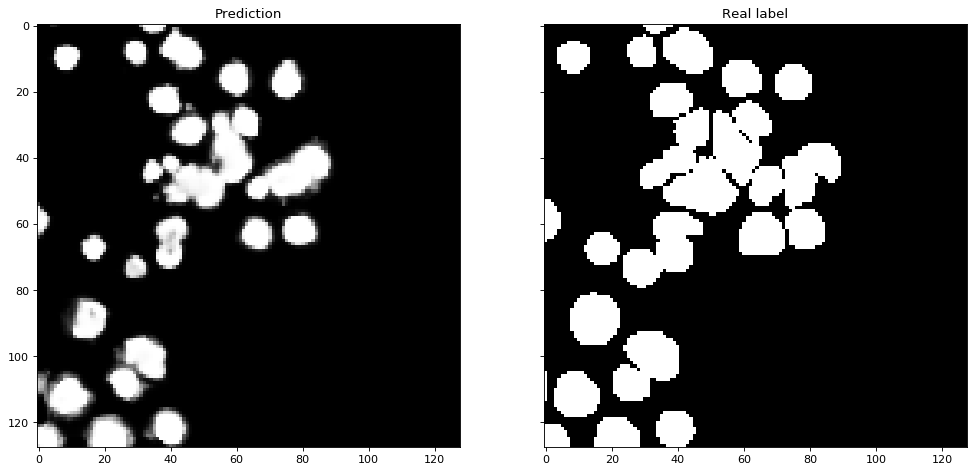

Network evaluation at epoch:  70 
train_avg_loss =  0.08569688742551732 , train_avg_f1_score =  0.8856234347146206 
val_avg_loss =  0.08733069336688173 , val_avg_f1_score =  0.8854903767148303
epoch: 71, train loss: 0.05753475711194437


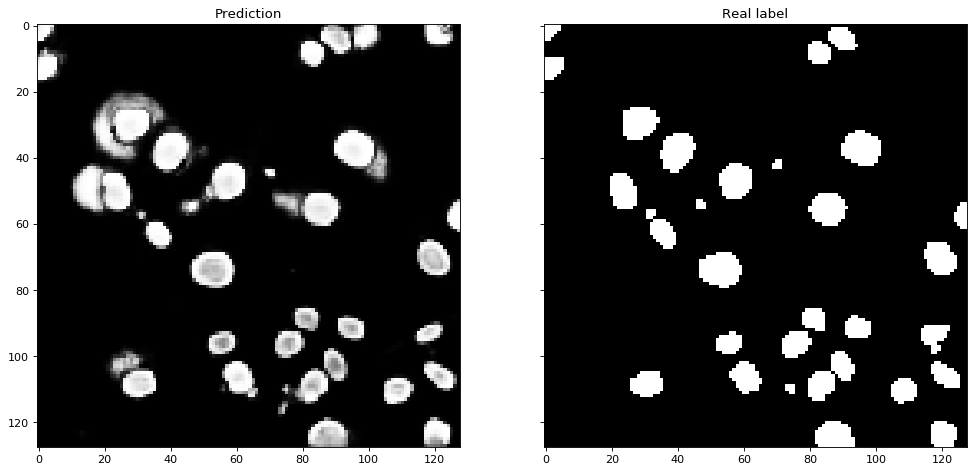

epoch: 72, train loss: 0.057160089487460125


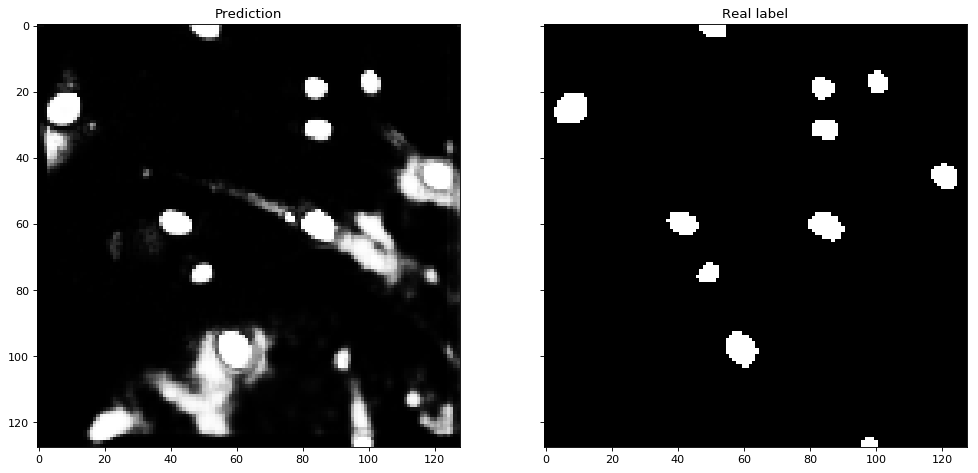

epoch: 73, train loss: 0.05810819610730925


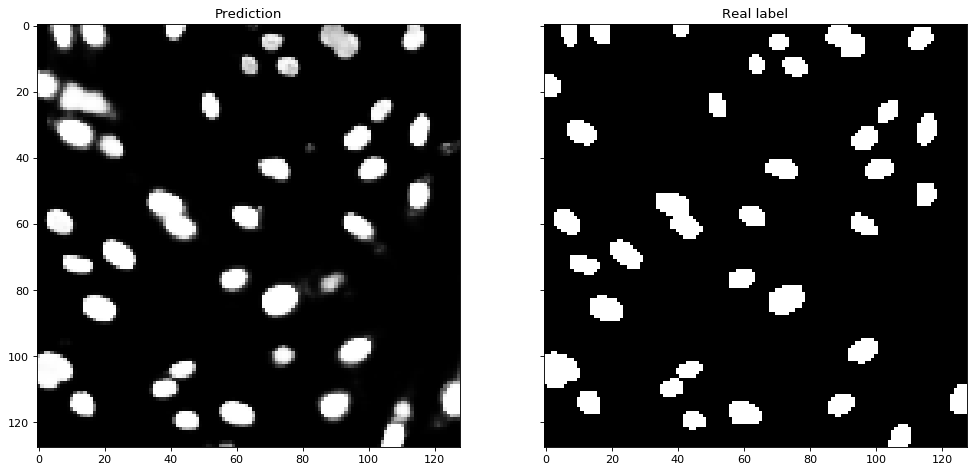

epoch: 74, train loss: 0.05463847648630391


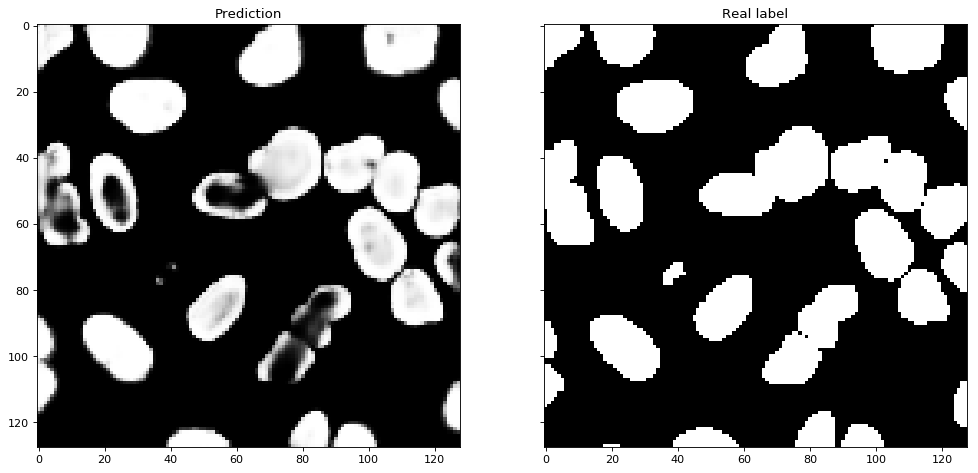

epoch: 75, train loss: 0.05421861669799285


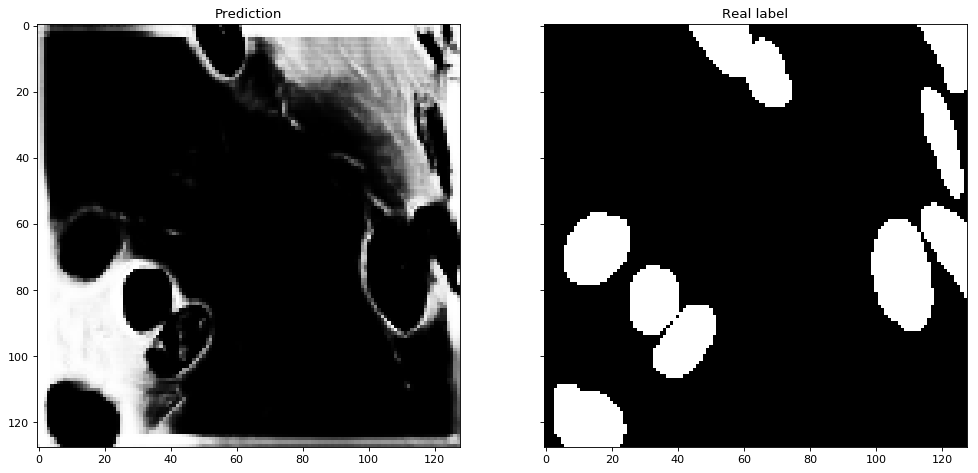

epoch: 76, train loss: 0.053479702615026214


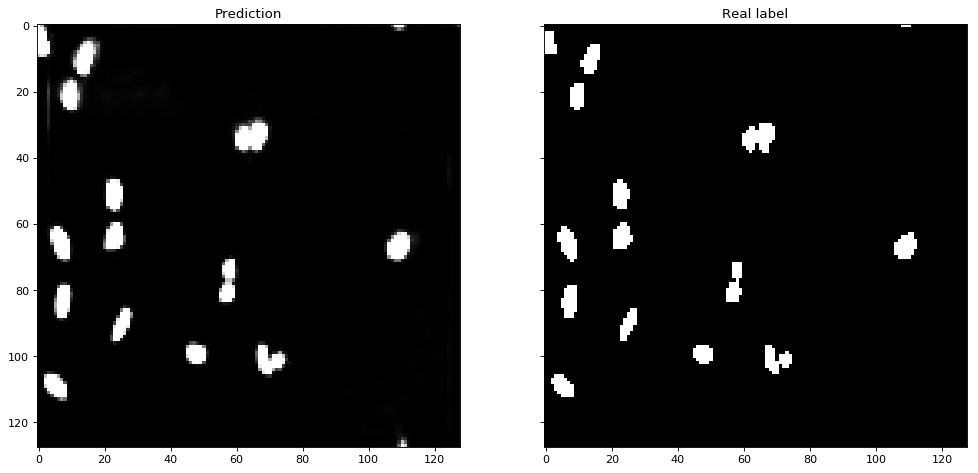

epoch: 77, train loss: 0.053211277712192105


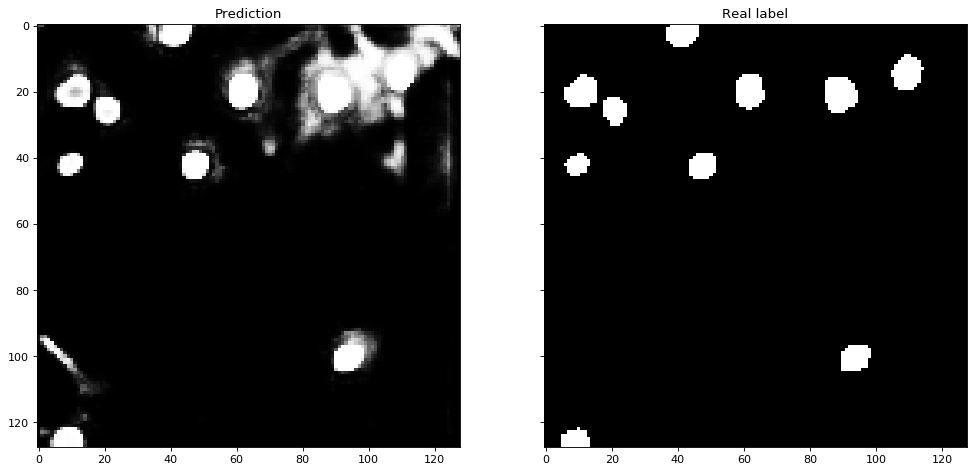

epoch: 78, train loss: 0.05285623041329099


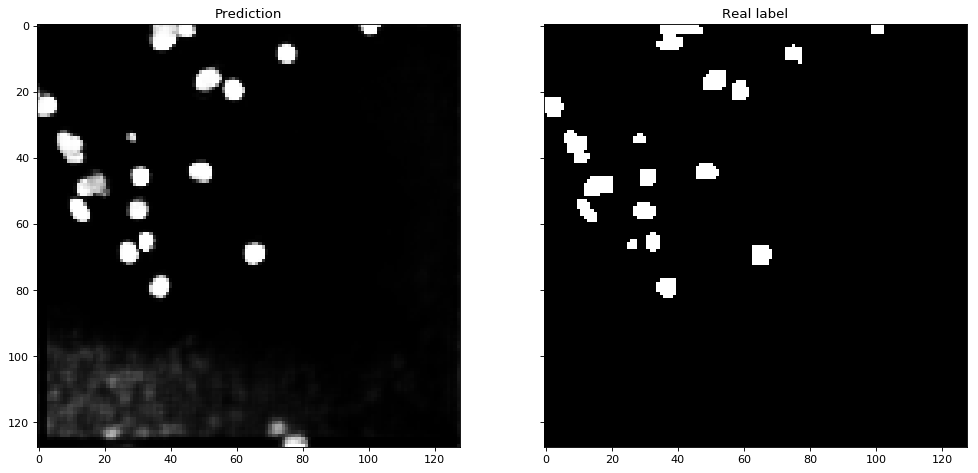

epoch: 79, train loss: 0.05231034388737892


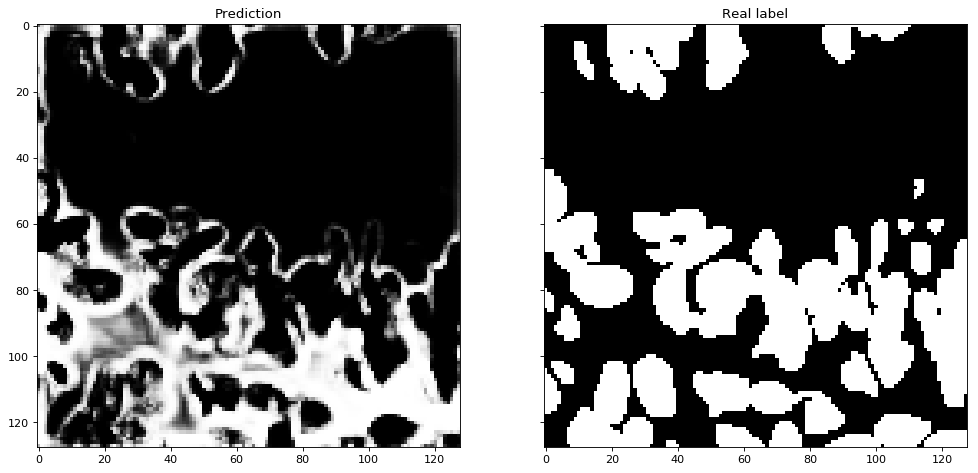

epoch: 80, train loss: 0.05225645803582313


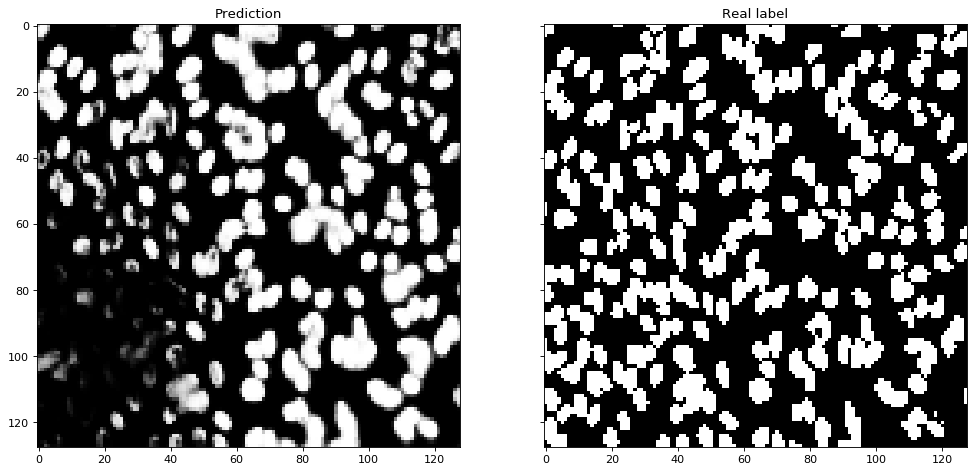

Network evaluation at epoch:  80 
train_avg_loss =  0.1511699903927745 , train_avg_f1_score =  0.857603471366454 
val_avg_loss =  0.1357957449109196 , val_avg_f1_score =  0.8720012152977632
epoch: 81, train loss: 0.05085407747928776


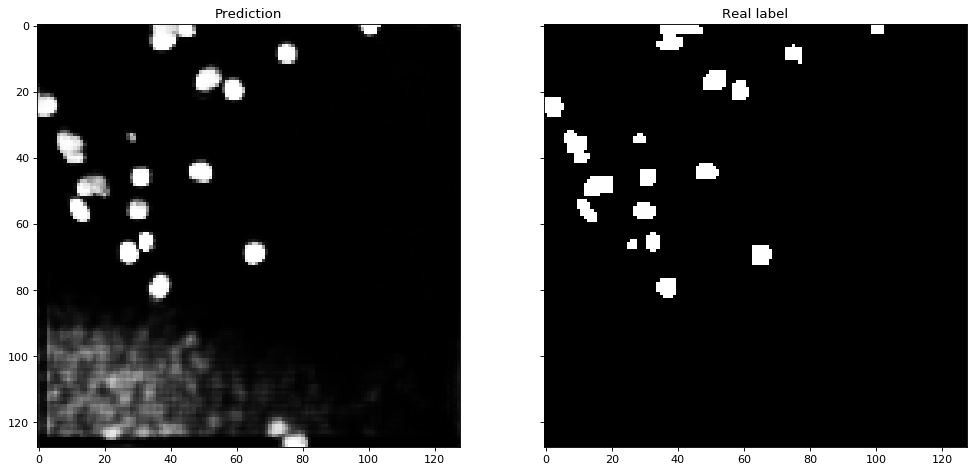

epoch: 82, train loss: 0.051415166136488985


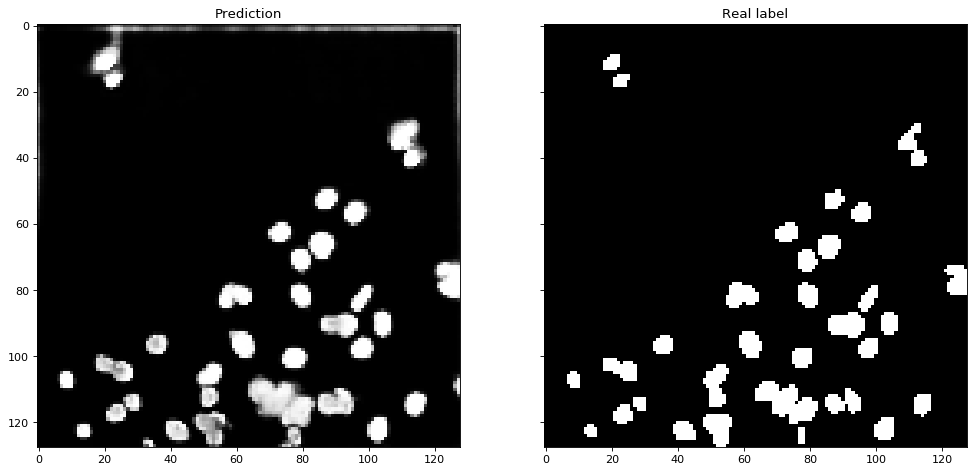

epoch: 83, train loss: 0.06050803061963907


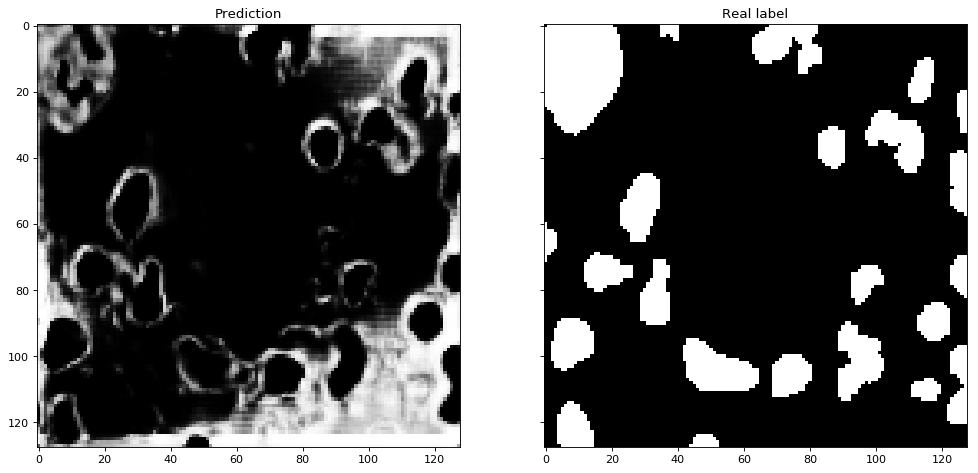

epoch: 84, train loss: 0.06113636046092012


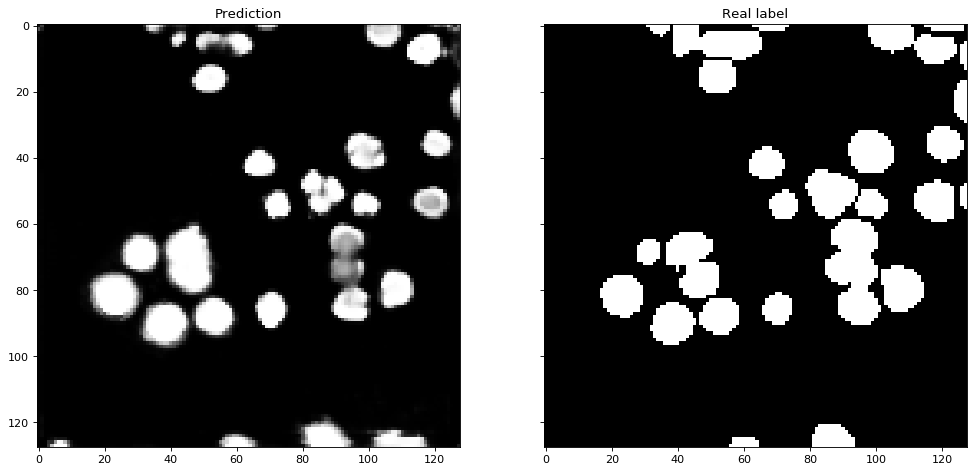

epoch: 85, train loss: 0.05687491159274507


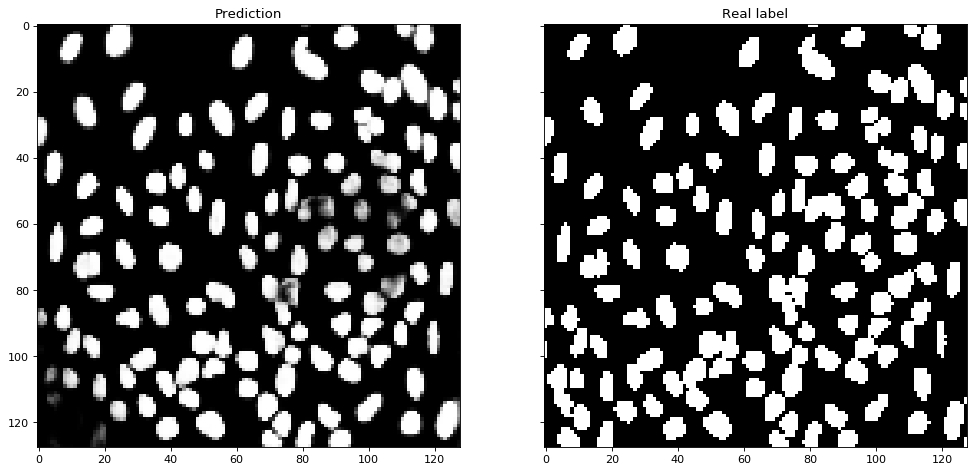

epoch: 86, train loss: 0.053321571714842496


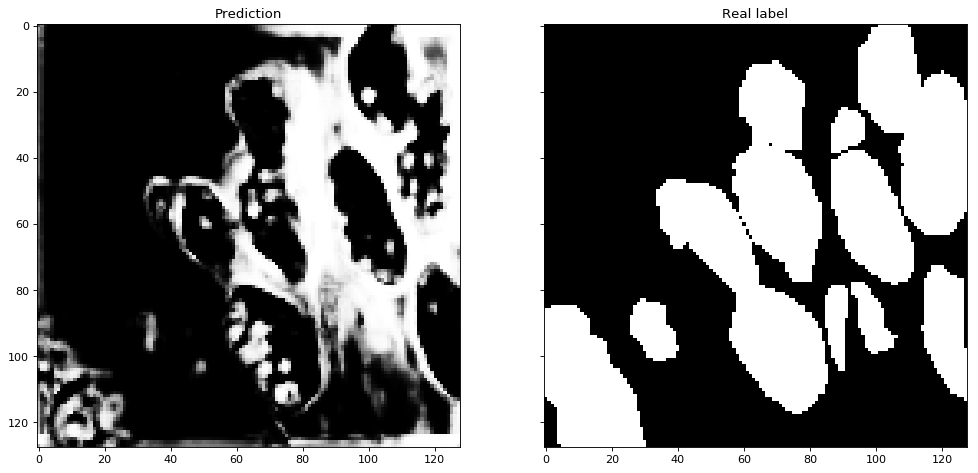

epoch: 87, train loss: 0.05270354127261176


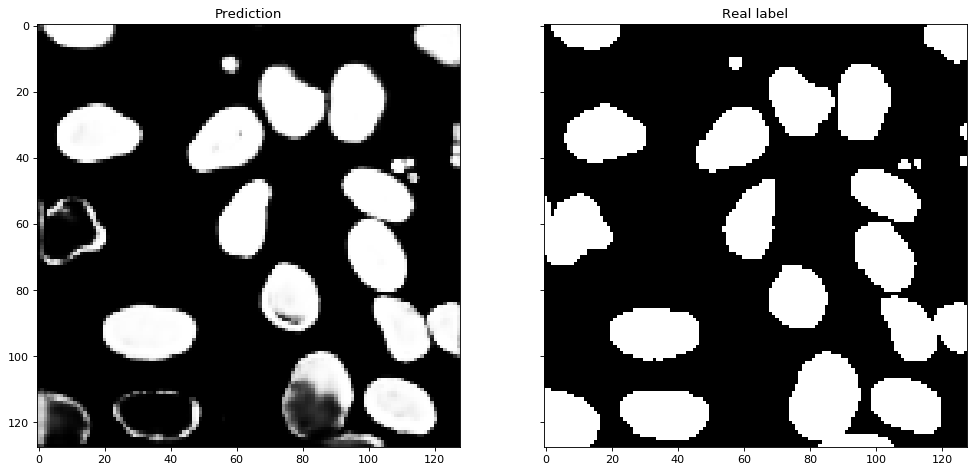

epoch: 88, train loss: 0.049717719263550064


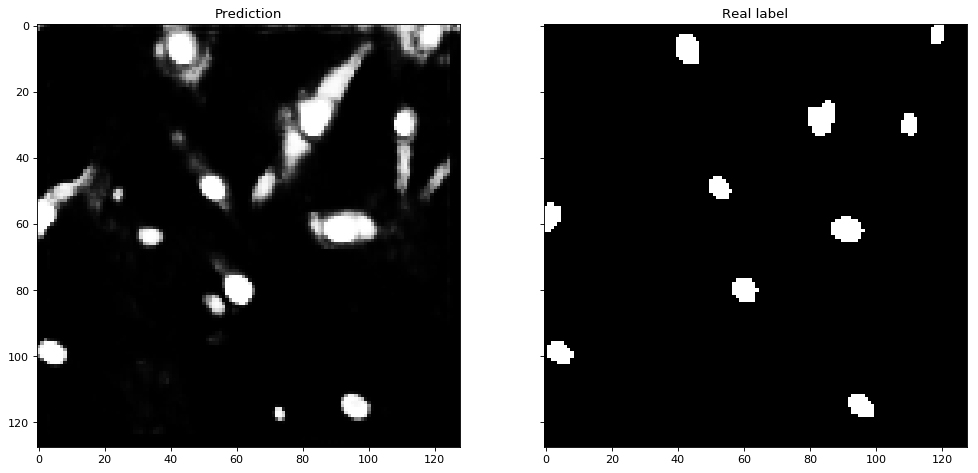

epoch: 89, train loss: 0.04878572599767749


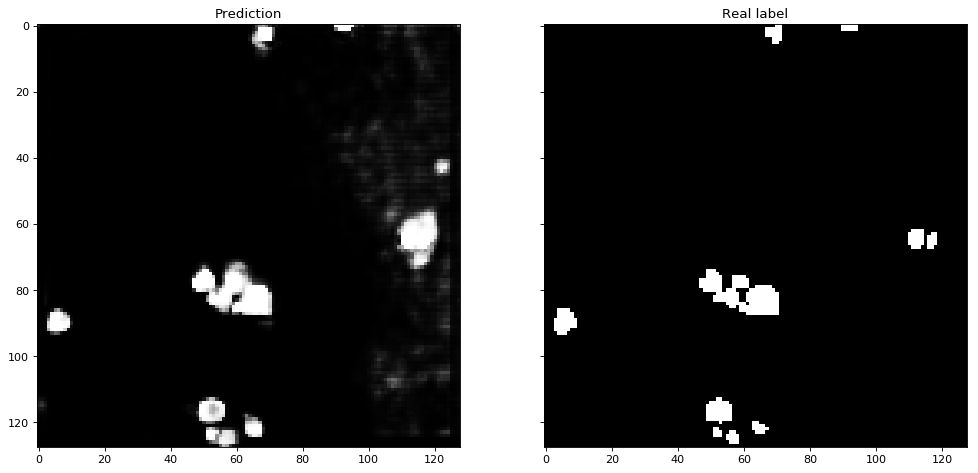

epoch: 90, train loss: 0.04944166602261031


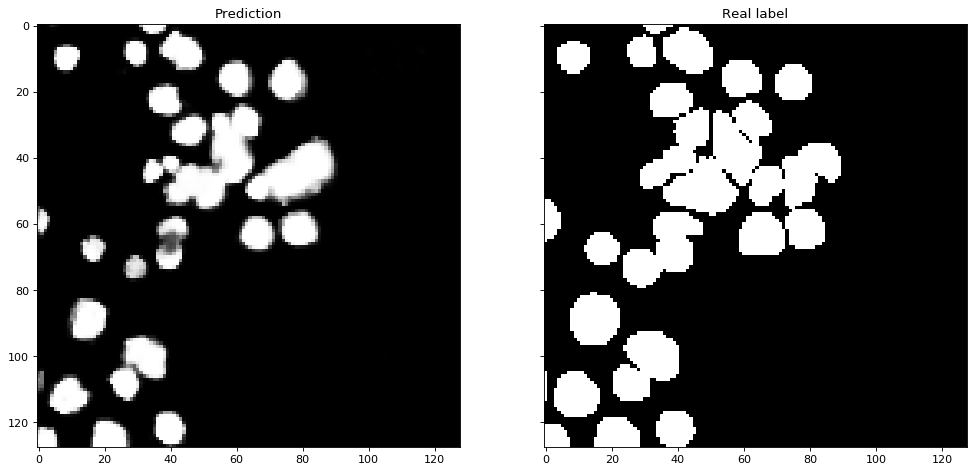

Network evaluation at epoch:  90 
train_avg_loss =  0.09128922337978694 , train_avg_f1_score =  0.8795180544554766 
val_avg_loss =  0.08856249734439622 , val_avg_f1_score =  0.8847078871206672
epoch: 91, train loss: 0.04908168691196548


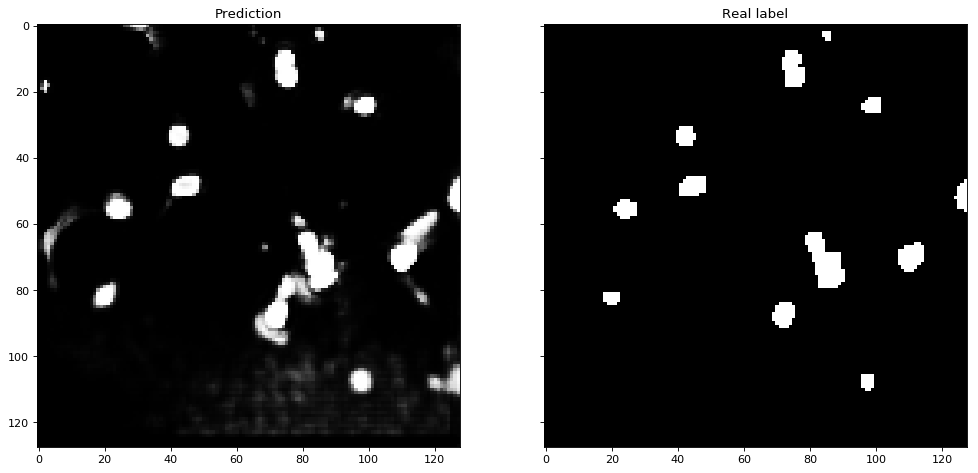

epoch: 92, train loss: 0.04959473614372424


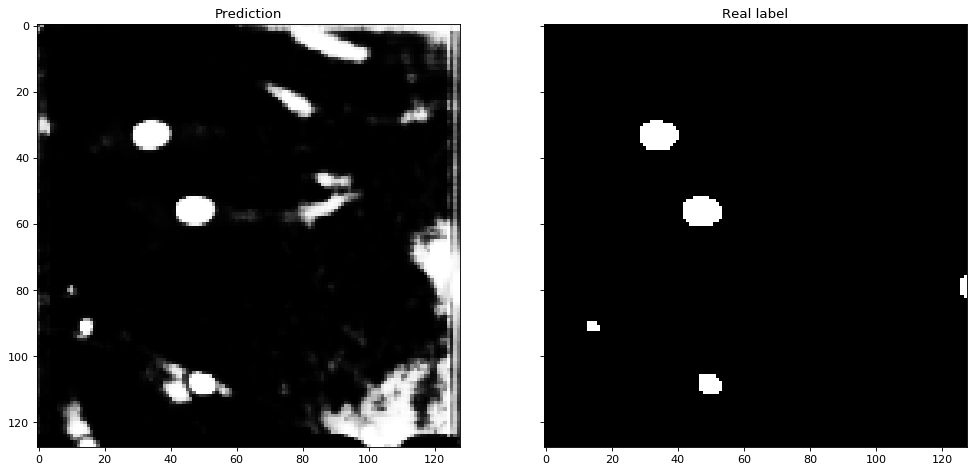

epoch: 93, train loss: 0.05071647009297983


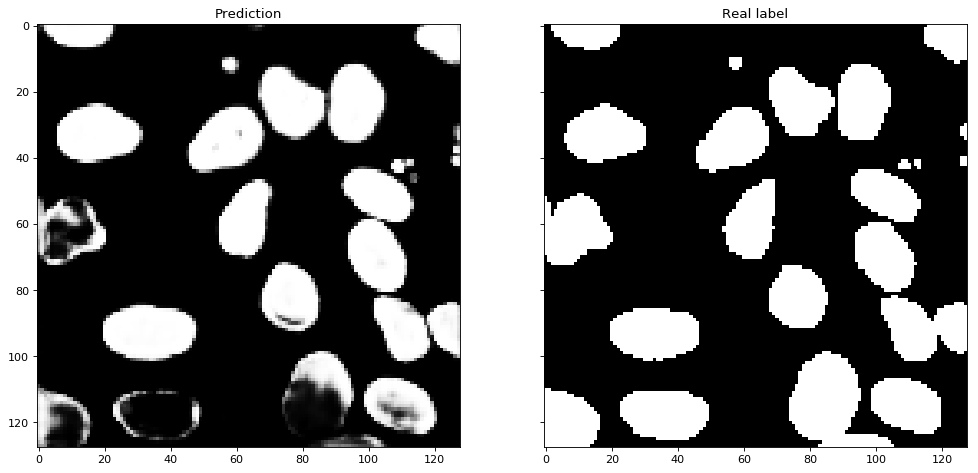

epoch: 94, train loss: 0.05048460260367216


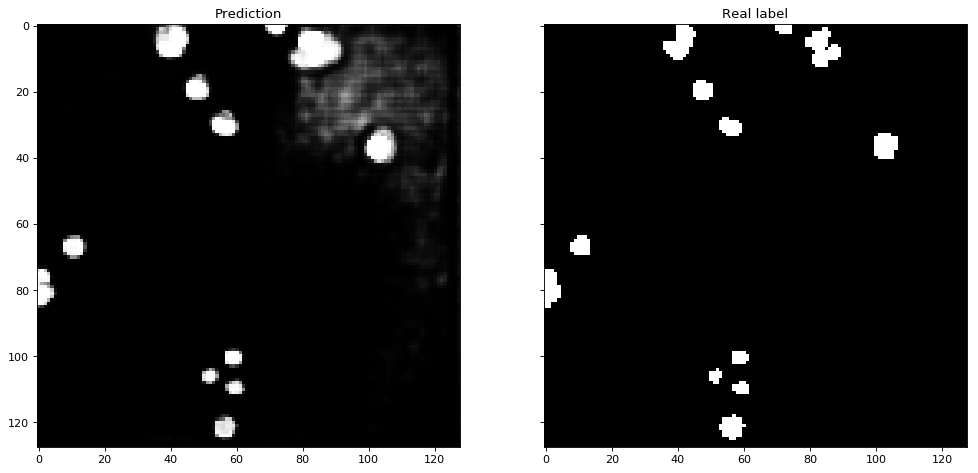

epoch: 95, train loss: 0.04738751843349257


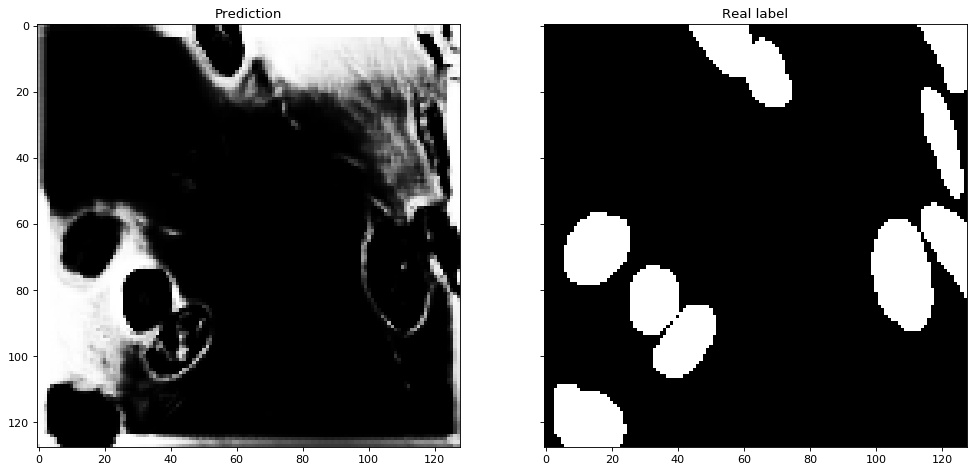

epoch: 96, train loss: 0.045962156922514756


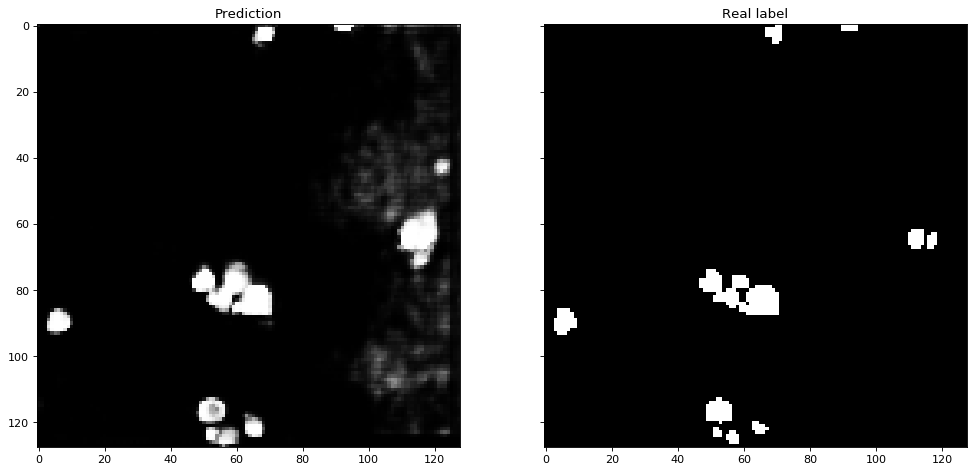

epoch: 97, train loss: 0.045498829223771596


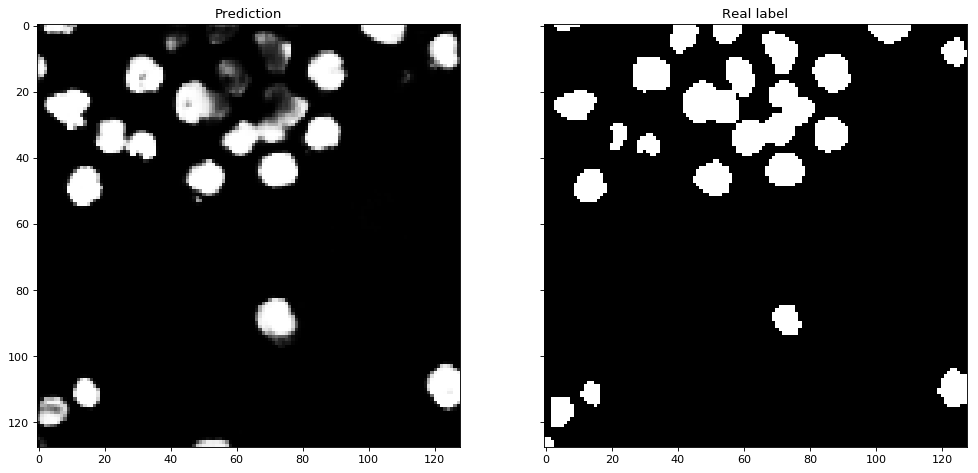

epoch: 98, train loss: 0.04550003952610848


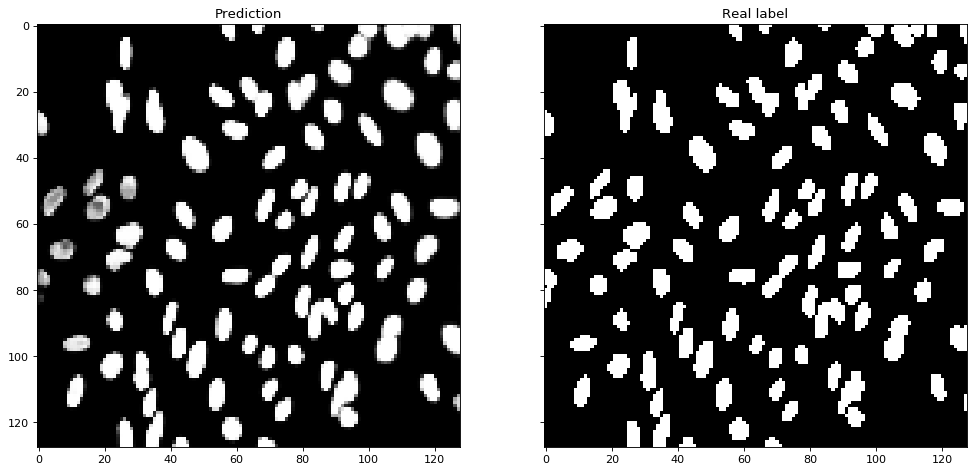

epoch: 99, train loss: 0.04517775657239245


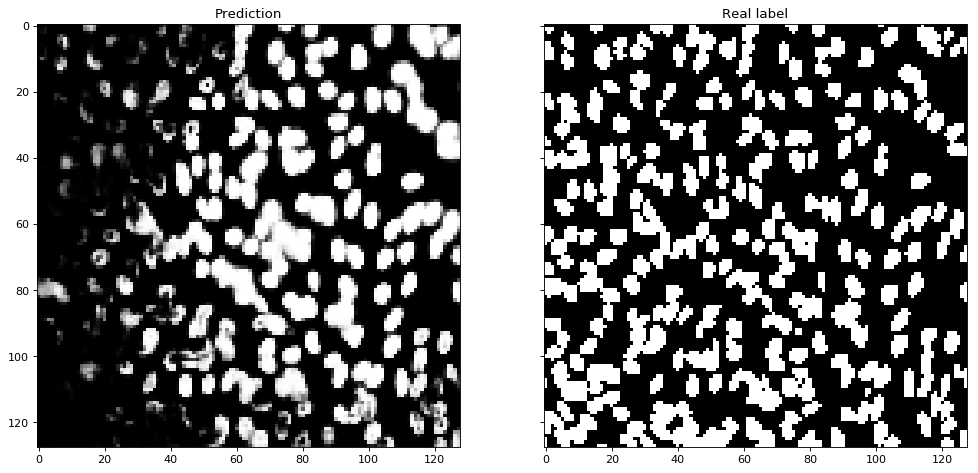

In [5]:
#unet(n_channels, n_classes, n_filters_start=64 )
un = unet(3,1)
if GPU: 
    un = un.cuda()

optimizer = torch.optim.Adam(un.parameters(), lr=0.01)
criterion = nn.BCELoss()




# split into training and validation set 
total_train_size = X_train.shape[0]
p = np.random.permutation(total_train_size)
X_train = X_train[p]
Y_train = Y_train[p]

val_size = int(0.2*total_train_size)

X_val = X_train[:val_size]
Y_val = Y_train[:val_size]

X_train = X_train[val_size:]
Y_train = Y_train[val_size:]

print("80/20 training/validation split")
print("total_train_size = ",total_train_size)
print("val_size = ", val_size)



# run training 
training(un,X_train, Y_train, X_val, Y_val, 100)


In [6]:
whos


Variable           Type        Data/Info
----------------------------------------
F                  module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
GPU                bool        True
Variable           type        <class 'torch.autograd.variable.Variable'>
X_train            ndarray     536x3x128x128: 26345472 elems, type `float64`, 210763776 bytes (201.0 Mb)
X_val              ndarray     134x3x128x128: 6586368 elems, type `float64`, 52690944 bytes (50.25 Mb)
Y_train            ndarray     536x1x128x128: 8781824 elems, type `uint8`, 8781824 bytes (8.375 Mb)
Y_val              ndarray     134x1x128x128: 2195456 elems, type `uint8`, 2195456 bytes (2.09375 Mb)
batch_size         int         8
conv_block         type        <class 'models.conv_block'>
criterion          BCELoss     BCELoss(\n)
eval_net           function    <function eval_net at 0x7fc077a3f048>
f1_score           function    <function f1_score at 0x7fc077a3f1e0>
io                 module      <module

# todo 

1. tune prediction threshold parameter 
2. disconnecting objects 
3. more datasets 
4. inception modules 